In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

253884
BIAS: 0.04868438617036245
RMS: 0.9858431048821934
corr: 0.9022297781905126
BIAS: -0.9831392605663711
RMS: 26.22688285471377
corr: 0.719437798405625


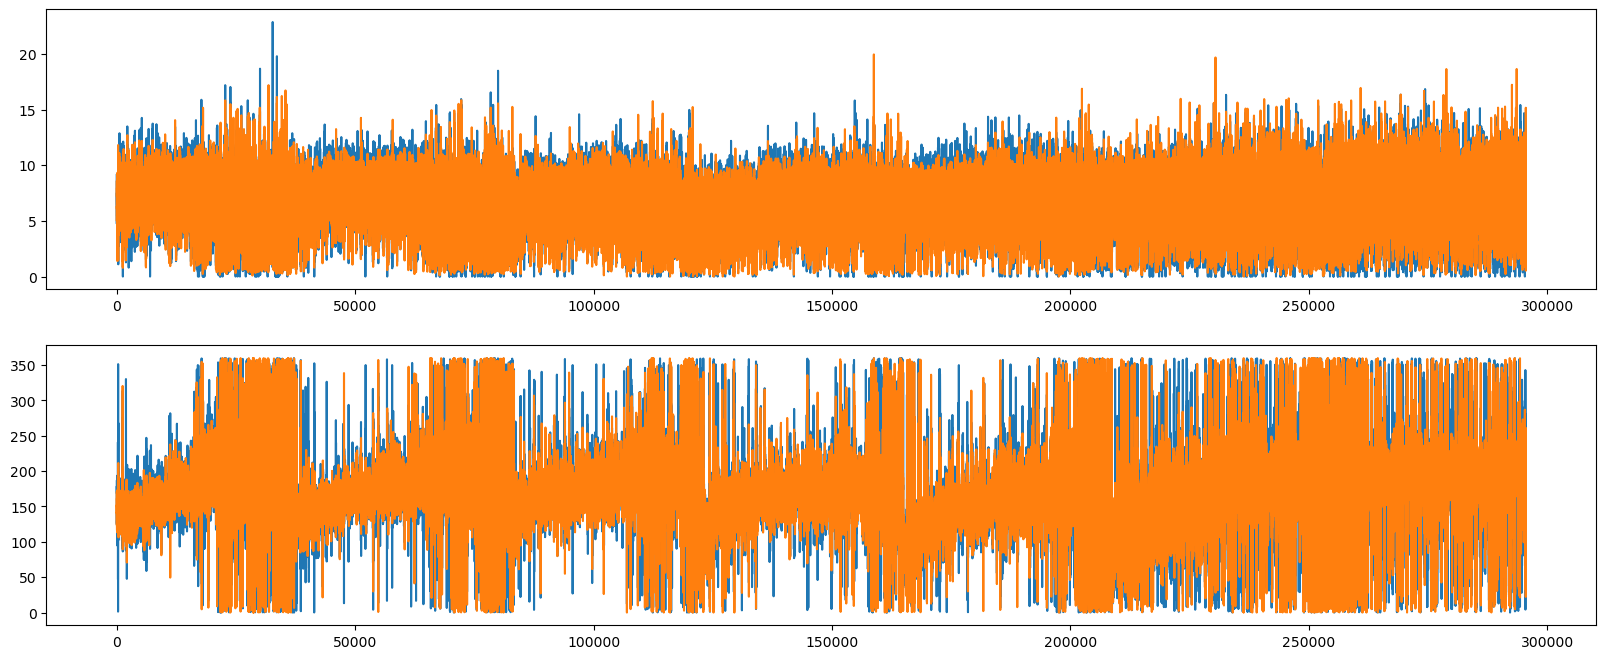

In [29]:
#ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')

#ds = xr.open_dataset('goodData_QSwithTAO_with2hrStatsConv.nc')
ds = xr.open_dataset('../testMatchups_frozenFlow/rainFlagRemovedBuoyDataFrozenBadQualityRemovedMatchupAmbuguitiesAdded_waveAndGlorysAdded_manualRemovedSomeData.nc')
df = ds.to_dataframe()

print(len(df))

fig, axes = plt.subplots(nrows =2, figsize = (20, 8))
axes[0].plot(df['WSPD_10N (TAO)'])
axes[0].plot(df['WSPD_10N (QuikSCAT)'])
print('BIAS:', np.mean(df['WSPD_DIFF (QuikSCAT - TAO)']))
print('RMS:', np.sqrt(np.mean(df['WSPD_DIFF (QuikSCAT - TAO)']**2)))
print('corr:', np.corrcoef(df['WSPD_10N (TAO)'], df['WSPD_10N (QuikSCAT)'])[0,1])

axes[1].plot(df['WDIR (TAO)'])
axes[1].plot(df['WDIR (QuikSCAT)'])
print('BIAS:',np.mean(df['WDIR_DIFF (QuikSCAT - TAO)']))
print('RMS:',np.sqrt(np.mean(df['WDIR_DIFF (QuikSCAT - TAO)']**2)))
print('corr:',np.corrcoef(df['WDIR (TAO)'], df['WDIR (QuikSCAT)'])[0,1])

253884
0.07803679830194678
0.8690311584008483
0.9224582849788404
-1.055350394087806
24.72185447268846
0.7418859356658762


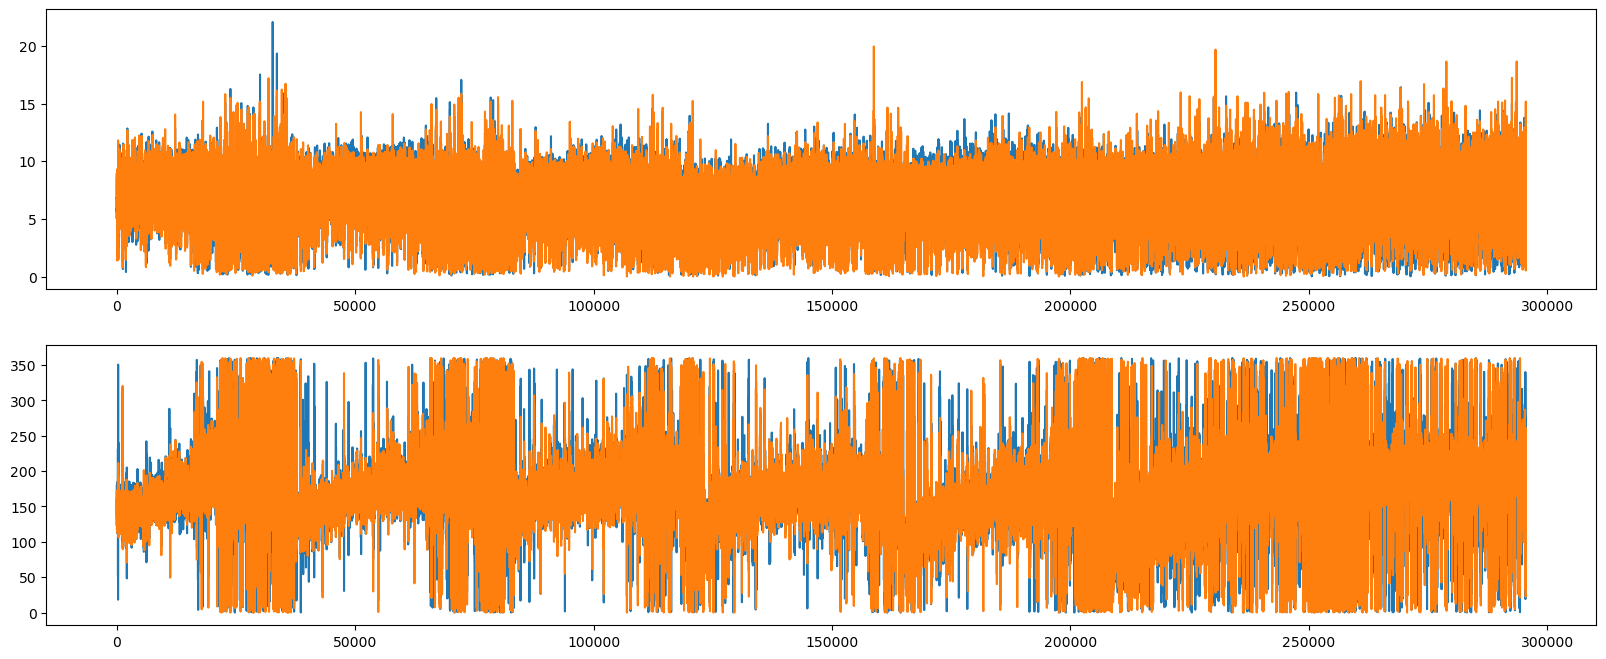

In [30]:
print(len(df))
fig, axes = plt.subplots(nrows =2, figsize = (20, 8))
axes[0].plot(df['WSPD_10N_FZ (TAO)'])
axes[0].plot(df['WSPD_10N (QuikSCAT)'])
print(np.mean(df['WSPD_DIFF_FZ (QuikSCAT - TAO)']))
print(np.sqrt(np.mean(df['WSPD_DIFF_FZ (QuikSCAT - TAO)']**2)))
print(np.corrcoef(df['WSPD_10N_FZ (TAO)'], df['WSPD_10N (QuikSCAT)'])[0,1])

axes[1].plot(df['WDIR_FZ (TAO)'])
axes[1].plot(df['WDIR (QuikSCAT)'])
print(np.mean(df['WDIR_DIFF_FZ (QuikSCAT - TAO)']))
print(np.sqrt(np.mean(df['WDIR_DIFF_FZ (QuikSCAT - TAO)']**2)))
print(np.corrcoef(df['WDIR_FZ (TAO)'], df['WDIR (QuikSCAT)'])[0,1])

In [31]:
df['intTimeInMin'] = np.array((df['fz_integrationTime'].to_numpy())/1e9/60, dtype=int)

In [32]:
df['intTimeInMin']

count
0          70
1          70
2          90
3          90
4          90
         ... 
295508    130
295509    130
295510    130
295511     90
295512     90
Name: intTimeInMin, Length: 253884, dtype: int64

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='intTimeInMin', ylabel='Count'>

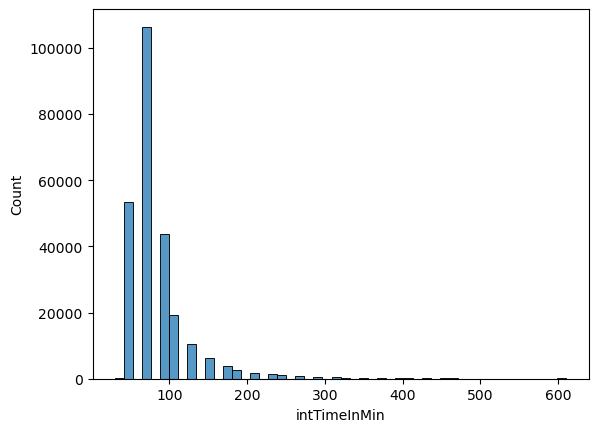

In [33]:
sns.histplot(df['intTimeInMin'], bins = 50)

In [34]:
ds

<xarray.Dataset>
Dimensions:                                   (count: 253884)
Coordinates:
  * count                                     (count) int64 0 1 ... 295512
Data variables: (12/140)
    WDIR (TAO)                                (count) float32 140.6 ... 143.2
    WDIR_QC                                   (count) float32 2.0 2.0 ... 2.0
    WDIR_DM                                   (count) |S1 b'D' b'D' ... b'D'
    WSPD (TAO)                                (count) float32 6.79 5.46 ... 4.23
    WSPD_QC                                   (count) float32 2.0 2.0 ... 2.0
    WSPD_DM                                   (count) |S1 b'D' b'D' ... b'D'
    ...                                        ...
    WSPD_DIFF_MN (QuikSCAT - TAO)             (count) float64 0.4913 ... 0.247
    WDIR_DIFF_MN (QuikSCAT - TAO)             (count) float64 3.544 ... -34.31
    cos(WDIR_DIFF_MN (QuikSCAT - TAO))        (count) float64 0.9981 ... 0.826
    sin(WDIR_DIFF_MN (QuikSCAT - TAO))        (count) float64 0.06181 ... -0....
    UWND_DIFF_MN (QuikSCAT - TAO)             (count) float64 -0.6527 ... 2.09
    VWND_DIFF_MN (QuikSCAT - TAO)             (count) float64 -0.003641 ... 1...

In [35]:
list(df.keys())

['WDIR (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'WSPD (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'UWND (TAO)',
 'VWND (TAO)',
 'SST (TAO)',
 'SST_QC',
 'SST_DM',
 'RELH (TAO)',
 'RELH_QC',
 'RELH_DM',
 'AIRT (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'WSPD_10N (TAO)',
 'WSPD_10 (TAO)',
 'VHM0',
 'VHM0_SW1',
 'VHM0_SW2',
 'VHM0_WW',
 'VMDR',
 'VMDR_SW1',
 'VMDR_SW2',
 'VMDR_WW',
 'VPED',
 'VSDX',
 'VSDY',
 'VTM01_SW1',
 'VTM01_SW2',
 'VTM01_WW',
 'VTM02',
 'VTM10',
 'VTPK',
 'WAVE_TIME',
 'vo',
 'zos',
 'uo',
 'thetao',
 'so',
 'GLORYS_TIME',
 'mean_WSPD',
 'std_WSPD',
 'mean_WSPD_10N',
 'std_WSPD_10N',
 'mean_UWND_10N',
 'std_UWND_10N',
 'mean_VWND_10N',
 'std_VWND_10N',
 'mean_WDIR',
 'std_WDIR',
 'mean_cosWDIR',
 'std_cosWDIR',
 'mean_sinWDIR',
 'std_sinWDIR',
 'mean_SST',
 'std_SST',
 'mean_AIRT',
 'std_AIRT',
 'mean_SST - AIRT',
 'std_SST - AIRT',
 'mean_RELH',
 'std_RELH',
 'WSPD_10N_FZ (TAO)',
 'UWND_10N_FZ',
 'VWND_10N_FZ',
 'WDIR_FZ (TAO)',
 'fz_std_WSPD_10N',
 'fz_std_cosWDIR',
 'fz_std_sinWDIR',
 'fz_in

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

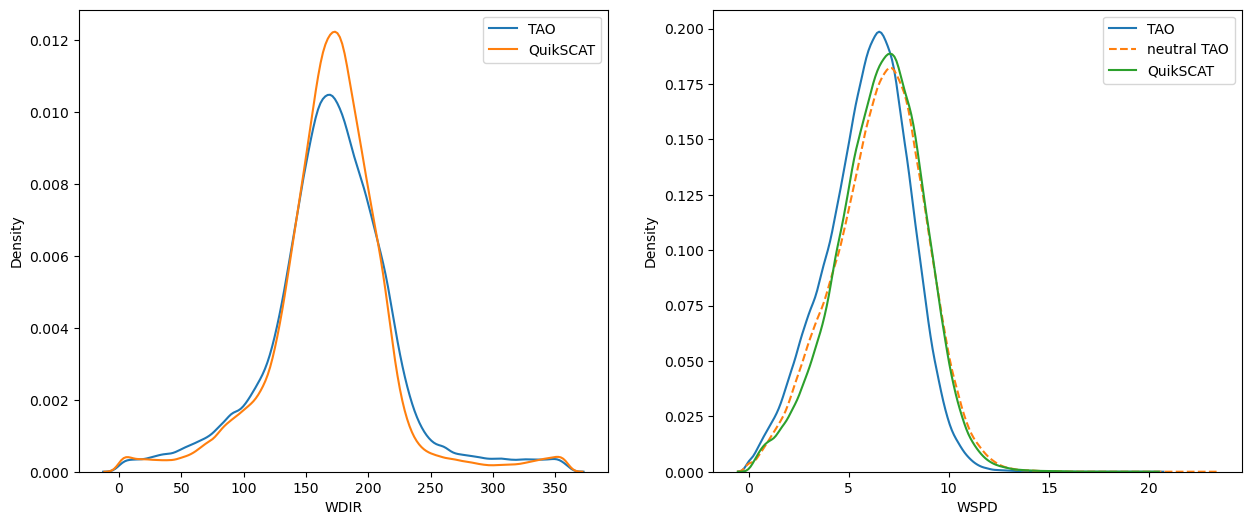

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['WDIR (TAO)'], ax = ax, label = 'TAO')
#sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
#sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
#sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['WDIR (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('WDIR')
ax.legend()

ax = axes[1]
sns.kdeplot(df['WSPD (TAO)'], ax = ax, label = 'TAO')
#sns.kdeplot(df['mean WSPD 30min'], ax = ax, label = 'TAO (30 min mean)')
#sns.kdeplot(df['mean WSPD 60min'], ax = ax, label = 'TAO (1 hr mean)')
#sns.kdeplot(df['mean WSPD 120min'], ax = ax, label = 'TAO (2 hr mean)')

sns.kdeplot(df['WSPD_10N (TAO)'], linestyle="--", ax = ax, label = 'neutral TAO')
#sns.kdeplot(df['mean WSPD_10N 30min'], linestyle="--", ax = ax, label = 'neutral TAO (30 min mean)')
#sns.kdeplot(df['mean WSPD_10N 60min'], linestyle="--", ax = ax, label = 'neutral TAO (1 hr mean)')
#sns.kdeplot(df['mean WSPD_10N 120min'], linestyle="--", ax = ax, label = 'neutral TAO (2 hr mean)')

sns.kdeplot(df['WSPD_10N (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('WSPD')
ax.legend()

0.9022297781905126

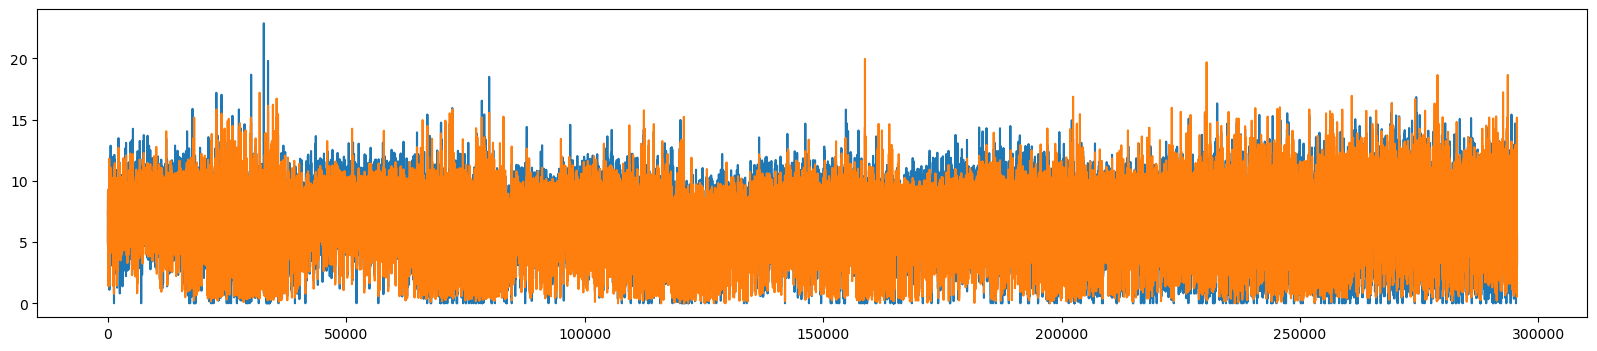

In [37]:
plt.figure(figsize=(20,4))
plt.plot(df['WSPD_10N (TAO)'])
plt.plot(df['WSPD_10N (QuikSCAT)'])
np.corrcoef(df['WSPD_10N (TAO)'], df['WSPD_10N (QuikSCAT)'])[0,1]

0.719437798405625

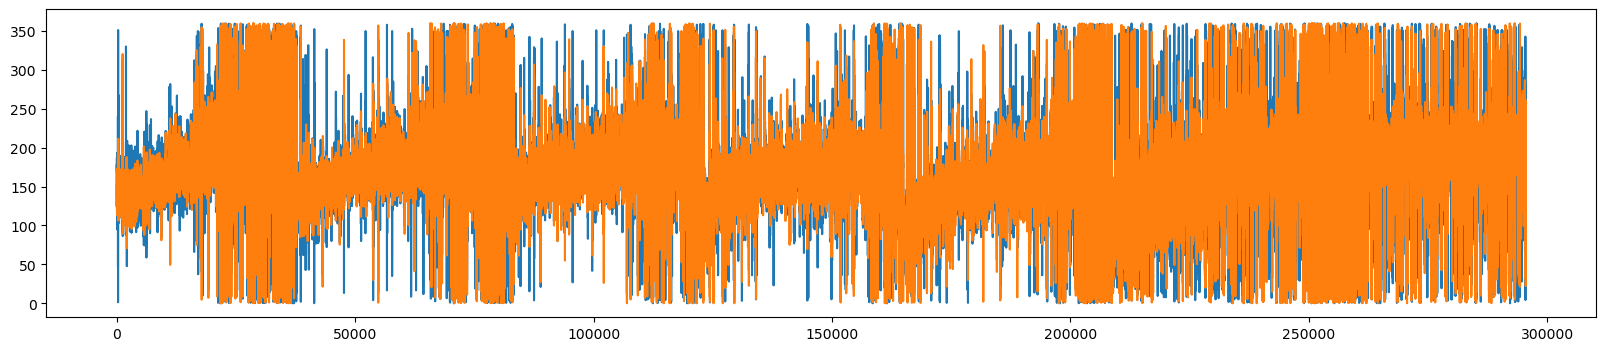

In [38]:
plt.figure(figsize=(20,4))
plt.plot(df['WDIR (TAO)'])
plt.plot(df['WDIR (QuikSCAT)'])
np.corrcoef(df['WDIR (TAO)'], df['WDIR (QuikSCAT)'])[0,1]

In [39]:
def getSpeedDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
            #TAOlabel = 'vec_mean_WSPD_10N'
        else:
            #TAOlabel = f'mean WSPD_10N {timeWindow}min'
            TAOlabel = 'mean_WSPD_10N'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSspeed) - np.mean(TAOspeed)
        return corr
    else:
        return -999

def getSpeedRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
            #TAOlabel = 'vec_mean_WSPD_10N'
        else:
            #TAOlabel = f'mean WSPD_10N {timeWindow}min'
            TAOlabel = 'mean_WSPD_10N'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
        return corr
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
            #TAOlabel = 'vec_mean_WSPD_10N'
        else:
            #TAOlabel = f'mean WSPD_10N {timeWindow}min'
            TAOlabel = 'mean_WSPD_10N'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

#########################################################################################3

def getDirDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
            #TAOlabel = 'mean_WDIR'
        else:
            #TAOlabel = f'mean WDIR {timeWindow}min'
            TAOlabel = np.rad2deg(np.arctan2(ds['mean_VWND_10N'], ds['mean_UWND_10N']))
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSdir)- np.mean(TAOdir)
        return corr
    else:
        return -999


def getDirRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
            #TAOlabel = 'mean_WDIR'
        else:
            #TAOlabel = f'mean WDIR {timeWindow}min'
            TAOlabel = np.rad2deg(np.arctan2(ds['mean_VWND_10N'], ds['mean_UWND_10N']))
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        diff = QSdir - TAOdir
        diff[diff>180] -= 360
        diff[diff<-180] += 360
        corr = np.sqrt(np.mean(diff**2))
        return corr
    else:
        return -999
        
def getDirCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
            #TAOlabel = 'mean_WDIR'
        else:
            #TAOlabel = f'mean WDIR {timeWindow}min'
            TAOlabel = np.rad2deg(np.arctan2(ds['mean_VWND_10N'], ds['mean_UWND_10N']))
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

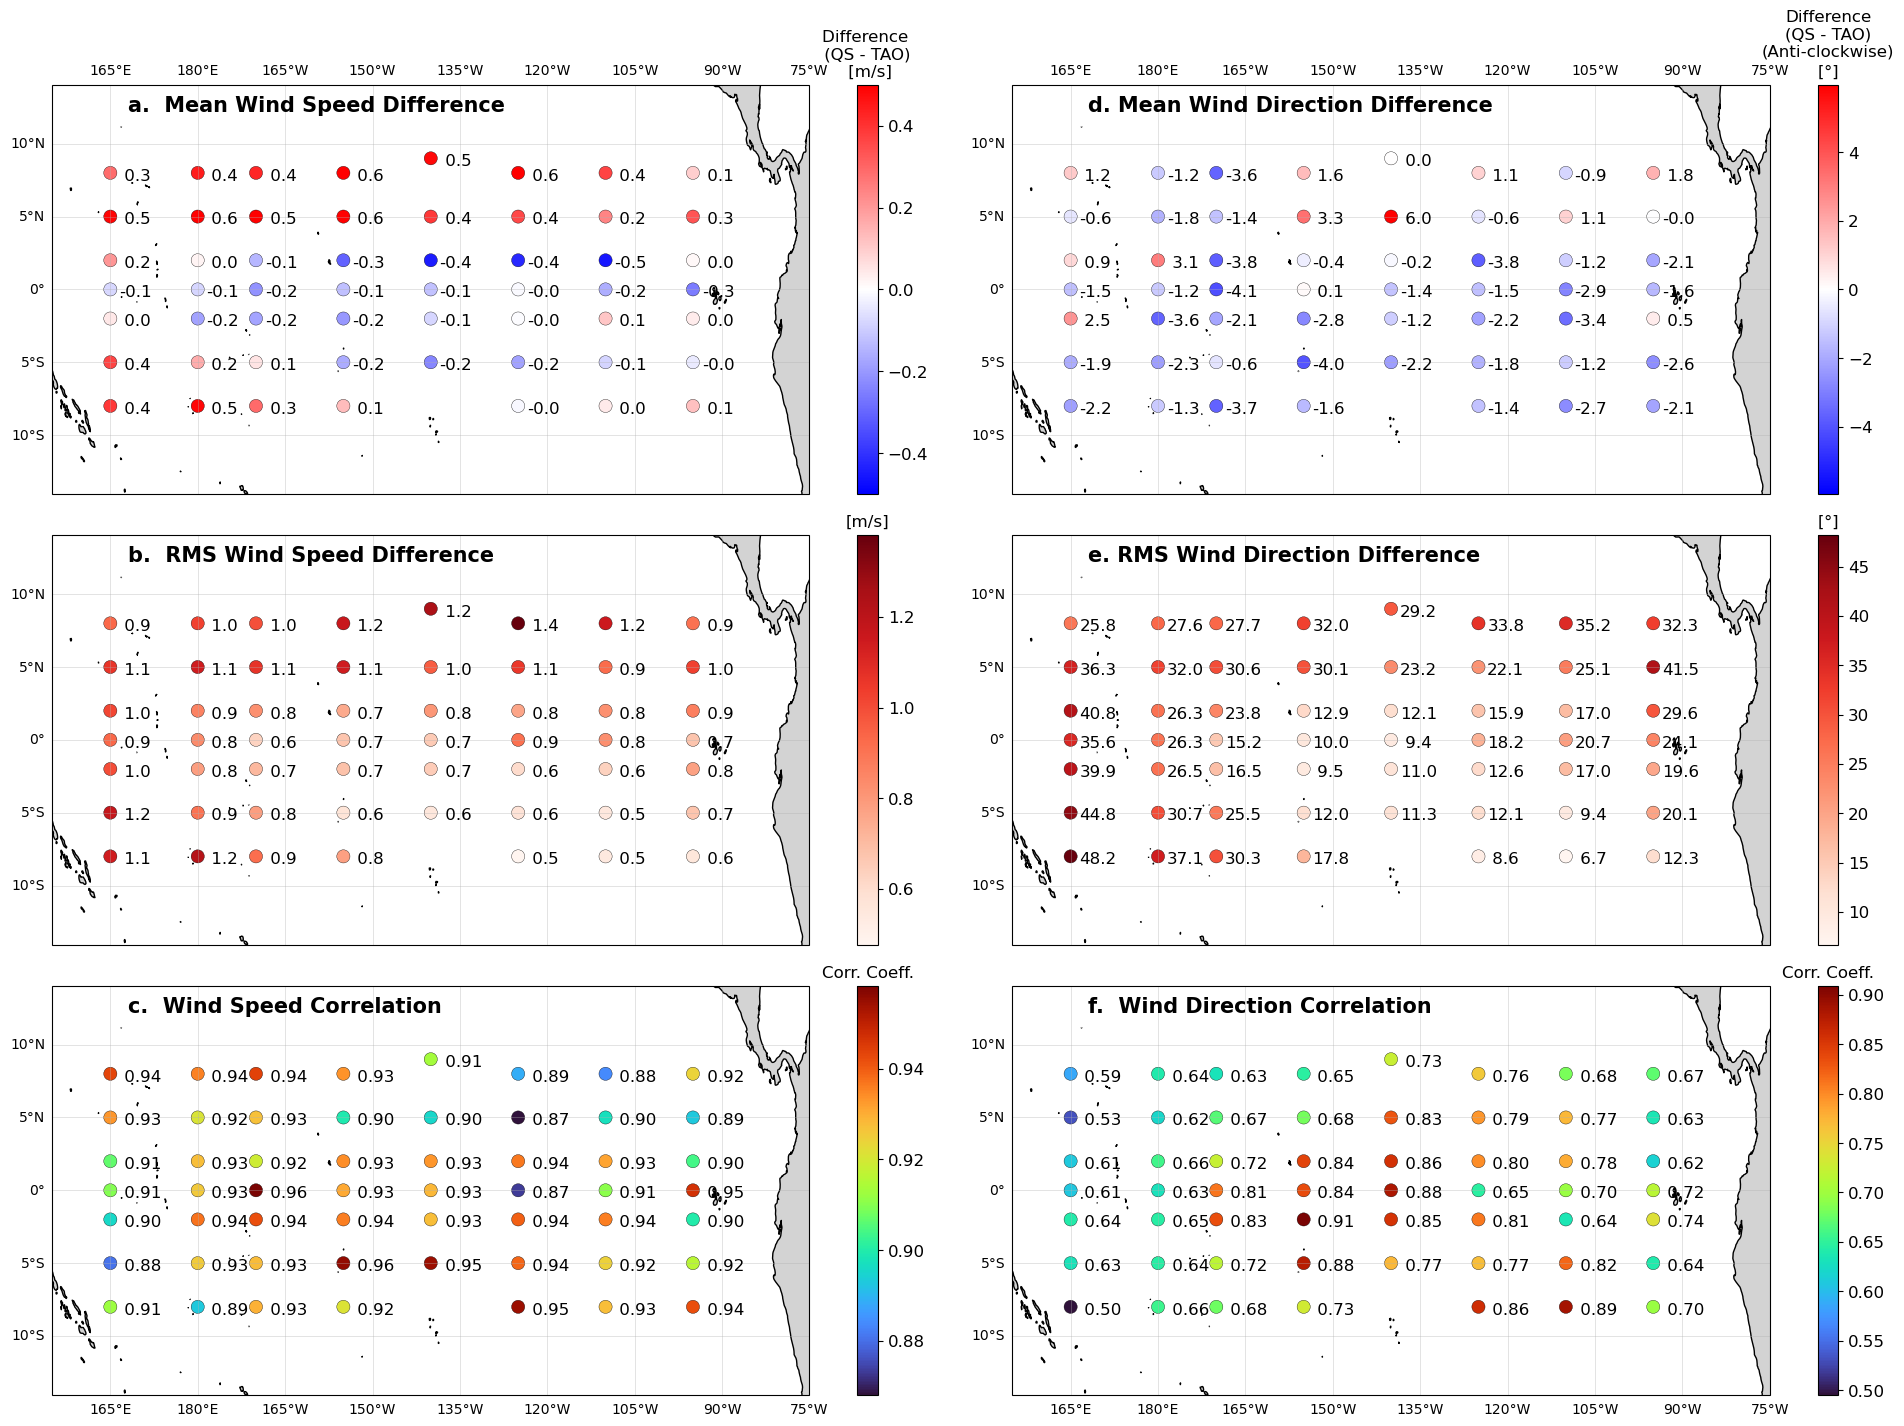

In [40]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  
                                   "aspect": 2.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
tickFsz = 10
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
# gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
# gridlines.xlocator = plt.FixedLocator([150, 180, 210, 240, 270])
# ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.5, vmax= 0.5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference \n (QS - TAO) \n [m/s]')

ax.text(0.1, 0.95, 'a.  Mean Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'b.  RMS Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'c.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -np.max(plotList[:,2]), vmax= np.max(plotList[:,2]))
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference\n(QS - TAO)\n(Anti-clockwise)\n' + r'[$\degree$]')

ax.text(0.1, 0.95, 'd. Mean Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'[$\degree$]')

ax.text(0.1, 0.95, 'e. RMS Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'f.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.93 , bottom = 0.02, wspace=0 , hspace=0.1)

plt.savefig('BasicStats_Frozen.pdf', dpi=100)

In [28]:
df['date'] = pd.to_datetime(df['QS_TIME'], errors='coerce')
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month

In [29]:
def getSpeedDifference_TS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((52), dtype=float)
        corr[:] = np.nan
        for i in range(52):
            ssubDF = subDF.loc[subDF['week'] == i]
            QSspeed = ssubDF['WSPD_10N (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.mean(QSspeed) - np.mean(TAOspeed)
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

def getSpeedRMSE_TS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((52), dtype=float)
        corr[:] = np.nan
        for i in range(52):
            ssubDF = subDF.loc[subDF['week'] == i]
            QSspeed = ssubDF['WSPD_10N (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]


def getSpeedCorrelation_TS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((52), dtype=float)
        corr[:] = np.nan
        for i in range(52):
            ssubDF = subDF.loc[subDF['week'] == i]
            QSspeed = ssubDF['WSPD_10N (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.corrcoef(QSspeed, TAOspeed)[0,1]
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

#########################################################################################

def getSpeedDifference_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSspeed = ssubDF['WSPD_10N (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.mean(QSspeed) - np.mean(TAOspeed)
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

def getSpeedRMSE_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSspeed = ssubDF['WSPD_10N (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]


def getSpeedCorrelation_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSspeed = ssubDF['WSPD_10N (QuikSCAT)'].to_numpy()
            TAOspeed = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.corrcoef(QSspeed, TAOspeed)[0,1]
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]

#########################################################################################3

#########################################################################################3

def getDirDifference_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSdir = ssubDF['WDIR (QuikSCAT)'].to_numpy()
            TAOdir = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.mean(QSdir)- np.mean(TAOdir)
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]


def getDirRMSE_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSdir = ssubDF['WDIR (QuikSCAT)'].to_numpy()
            TAOdir = ssubDF[TAOlabel].to_numpy()
            diff = QSdir - TAOdir
            diff[diff>180] -= 360
            diff[diff<-180] += 360
            if len(ssubDF) > 10:
                corr[i] = np.sqrt(np.mean(diff**2))
            else:
                corr[i] = np.nan
        return corr
    else:
        return [-999]
        
def getDirCorrelation_mTS(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        corr = np.zeros((12), dtype=float)
        corr[:] = np.nan
        for i in range(12):
            ssubDF = subDF.loc[subDF['month'] == i+1]
            QSdir = ssubDF['WDIR (QuikSCAT)'].to_numpy()
            TAOdir = ssubDF[TAOlabel].to_numpy()
            if len(ssubDF) > 10:
                corr[i] = np.corrcoef(QSdir, TAOdir)[0,1]
            else:
                corr[i] = np.nan
                
        return corr
    else:
        return [-999]



In [30]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

taskList = [(lat, lon) for lat in latList for lon in lonList]

records = []

kernel = np.ones(3, dtype=float) / 3.0

for lat, lon in taskList:
    corr = getSpeedCorrelation_mTS(lat, lon, df)
    diff = getSpeedDifference_mTS(lat, lon, df)
    rmse = getSpeedRMSE_mTS(lat, lon, df)

    # Ensure valid input
    if isinstance(corr, (list, np.ndarray)) and len(corr) >= 12:

        # Pad each 12-element series to length 16 for convolution
        padded_corr = np.zeros(16)
        padded_corr[2:14] = corr
        padded_corr[0:2] = corr[-2:]
        padded_corr[14:] = corr[:2]

        padded_diff = np.zeros(16)
        padded_diff[2:14] = diff
        padded_diff[0:2] = diff[-2:]
        padded_diff[14:] = diff[:2]

        padded_rmse = np.zeros(16)
        padded_rmse[2:14] = rmse
        padded_rmse[0:2] = rmse[-2:]
        padded_rmse[14:] = rmse[:2]

        # Location label
        lonUnit = 'E' if lon > 0 else 'W'
        latUnit = 'N' if lat > 0 else 'S'
        label = f'({abs(lon)}{lonUnit}, {abs(lat)}{latUnit})'

        norm_rmse = (rmse -np.mean(rmse))/np.std(rmse)
        padded_norm_rmse = np.zeros(16)
        padded_norm_rmse[2:14] = norm_rmse
        padded_norm_rmse[0:2] = norm_rmse[-2:]
        padded_norm_rmse[14:] = norm_rmse[:2]
        
        XX_bar = np.convolve(padded_norm_rmse**2, kernel, mode='valid')
        X_bar = np.convolve(padded_norm_rmse, kernel, mode='valid')
        mean_3month_var_of_normalized_RMSE = np.mean(XX_bar - X_bar * X_bar)

        record = {
            'lat': lat, 
            'lon' : lon, 
            'loc': label,
            'diff': diff,
            'corr': corr,
            'rmse': rmse,
            
            'max_diff_month': np.argmax(diff),
            'min_diff_month': np.argmin(diff),
            'max_rmse_month': np.argmax(rmse),
            'min_rmse_month': np.argmin(rmse),
            'max_corr_month': np.argmax(corr),
            'min_corr_month': np.argmin(corr),
            
            # 'max_diff_month': np.argmax(np.convolve(padded_diff, kernel, mode='valid')),
            # 'min_diff_month': np.argmin(np.convolve(padded_diff, kernel, mode='valid')),
            # 'max_rmse_month': np.argmax(np.convolve(padded_rmse, kernel, mode='valid')),
            # 'min_rmse_month': np.argmin(np.convolve(padded_rmse, kernel, mode='valid')),
            # 'max_corr_month': np.argmax(np.convolve(padded_corr, kernel, mode='valid')),
            # 'min_corr_month': np.argmin(np.convolve(padded_corr, kernel, mode='valid')),

            'mean_3month_var_of_normalized_RMSE' : mean_3month_var_of_normalized_RMSE,
        }

        records.append(record)

# Final DataFrame
speedSeasonalityDF = pd.DataFrame(records)

In [31]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

taskList = [(lat, lon) for lat in latList for lon in lonList]

records = []

kernel = np.ones(3, dtype=float) / 3.0

for lat, lon in taskList:
    corr = getDirCorrelation_mTS(lat, lon, df)
    diff = getDirDifference_mTS(lat, lon, df)
    rmse = getDirRMSE_mTS(lat, lon, df)

    # Ensure valid input
    if isinstance(corr, (list, np.ndarray)) and len(corr) >= 12:

        # Pad each 12-element series to length 16 for convolution
        padded_corr = np.zeros(16)
        padded_corr[2:14] = corr
        padded_corr[0:2] = corr[-2:]
        padded_corr[14:] = corr[:2]

        padded_diff = np.zeros(16)
        padded_diff[2:14] = diff
        padded_diff[0:2] = diff[-2:]
        padded_diff[14:] = diff[:2]

        padded_rmse = np.zeros(16)
        padded_rmse[2:14] = rmse
        padded_rmse[0:2] = rmse[-2:]
        padded_rmse[14:] = rmse[:2]

        # Location label
        lonUnit = 'E' if lon > 0 else 'W'
        latUnit = 'N' if lat > 0 else 'S'
        label = f'({abs(lon)}{lonUnit}, {abs(lat)}{latUnit})'

        norm_rmse = (rmse -np.mean(rmse))/np.std(rmse)
        padded_norm_rmse = np.zeros(16)
        padded_norm_rmse[2:14] = norm_rmse
        padded_norm_rmse[0:2] = norm_rmse[-2:]
        padded_norm_rmse[14:] = norm_rmse[:2]
        
        XX_bar = np.convolve(padded_norm_rmse**2, kernel, mode='valid')
        X_bar = np.convolve(padded_norm_rmse, kernel, mode='valid')
        mean_3month_var_of_normalized_RMSE = np.mean(XX_bar - X_bar * X_bar)

        record = {
            'lat': lat, 
            'lon' : lon, 
            'loc': label,
            'diff': diff,
            'corr': corr,
            'rmse': rmse,
            
            'max_diff_month': np.argmax(diff),
            'min_diff_month': np.argmin(diff),
            'max_rmse_month': np.argmax(rmse),
            'min_rmse_month': np.argmin(rmse),
            'max_corr_month': np.argmax(corr),
            'min_corr_month': np.argmin(corr),
            
            # 'max_diff_month': np.argmax(np.convolve(padded_diff, kernel, mode='valid')),
            # 'min_diff_month': np.argmin(np.convolve(padded_diff, kernel, mode='valid')),
            # 'max_rmse_month': np.argmax(np.convolve(padded_rmse, kernel, mode='valid')),
            # 'min_rmse_month': np.argmin(np.convolve(padded_rmse, kernel, mode='valid')),
            # 'max_corr_month': np.argmax(np.convolve(padded_corr, kernel, mode='valid')),
            # 'min_corr_month': np.argmin(np.convolve(padded_corr, kernel, mode='valid')),


            'mean_3month_var_of_normalized_RMSE': mean_3month_var_of_normalized_RMSE,
        }

        records.append(record)

# Final DataFrame
dirSeasonalityDF = pd.DataFrame(records)



In [32]:
dirSeasonalityDF['max_rmse_month']

0      2
1      4
2      2
3      9
4      2
5      2
6      2
7      2
8      2
9      2
10     5
11     4
12    11
13     4
14     2
15     2
16     2
17     2
18     3
19    11
20     4
21     4
22     2
23     2
24     3
25     2
26    11
27     9
28    10
29     6
30     2
31     2
32     2
33     3
34    11
35    11
36     6
37     6
38    11
39     3
40     3
41     5
42    10
43     6
44     7
45     8
46    10
47     4
48    10
49     8
50     7
51     9
52     9
53     9
Name: max_rmse_month, dtype: int64

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='mean_3month_var_of_normalized_RMSE', ylabel='Density'>

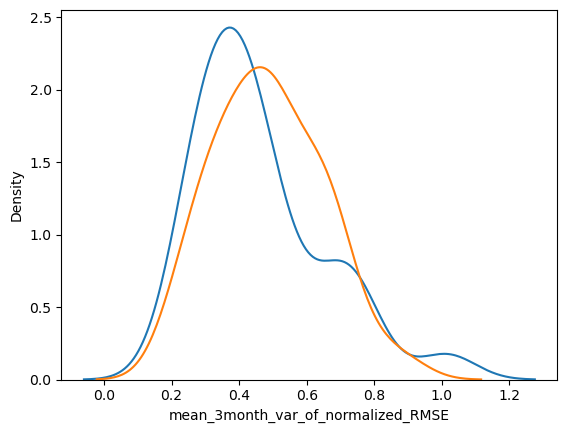

In [33]:
sns.kdeplot(dirSeasonalityDF['mean_3month_var_of_normalized_RMSE'])
sns.kdeplot(speedSeasonalityDF['mean_3month_var_of_normalized_RMSE'])

In [34]:
goodSpeedSeason = speedSeasonalityDF.loc[speedSeasonalityDF['mean_3month_var_of_normalized_RMSE'] < 0.6]
goodDirSeason = dirSeasonalityDF.loc[speedSeasonalityDF['mean_3month_var_of_normalized_RMSE'] < 0.6]

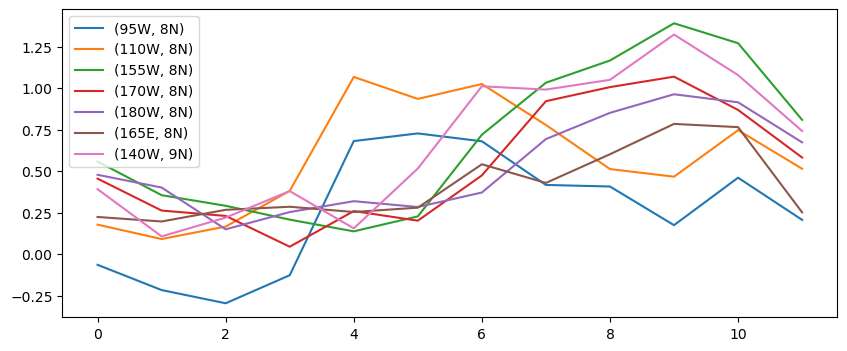

In [35]:
# Convert 'difference' column to a 2D array (n_sites x 12 months)
#this_df = speedSeasonalityDF.loc[speedSeasonalityDF['lat'] > 5]
this_df = goodSpeedSeason.loc[speedSeasonalityDF['lat'] > 5]
array = np.vstack(this_df['diff'].to_numpy())
labels = list(this_df['loc'])
# Plot all sites' seasonal difference curves in JFM
plt.figure(figsize=(10, 4))
for label, row in zip(labels, array):
    #if label not in ignore_list:
        plt.plot(row, label = label)
plt.legend()

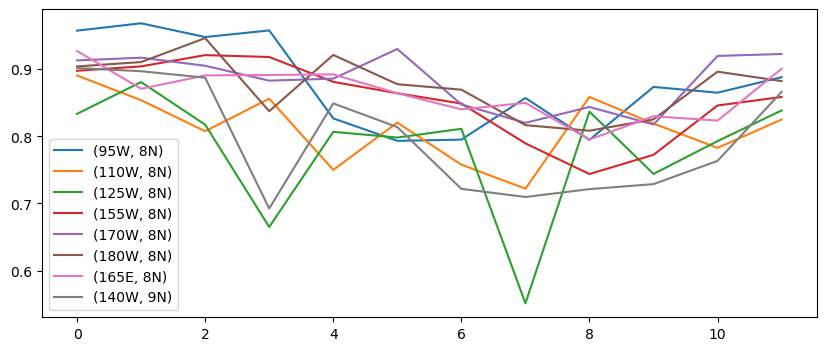

In [36]:
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = speedSeasonalityDF.loc[speedSeasonalityDF['lat'] > 5]
array = np.vstack(this_df['corr'].to_numpy())
labels = list(this_df['loc'])
# Plot all sites' seasonal difference curves in JFM
plt.figure(figsize=(10, 4))
for label, row in zip(labels, array):
    #if label not in ignore_list:
        plt.plot(row, label = label)
plt.legend()

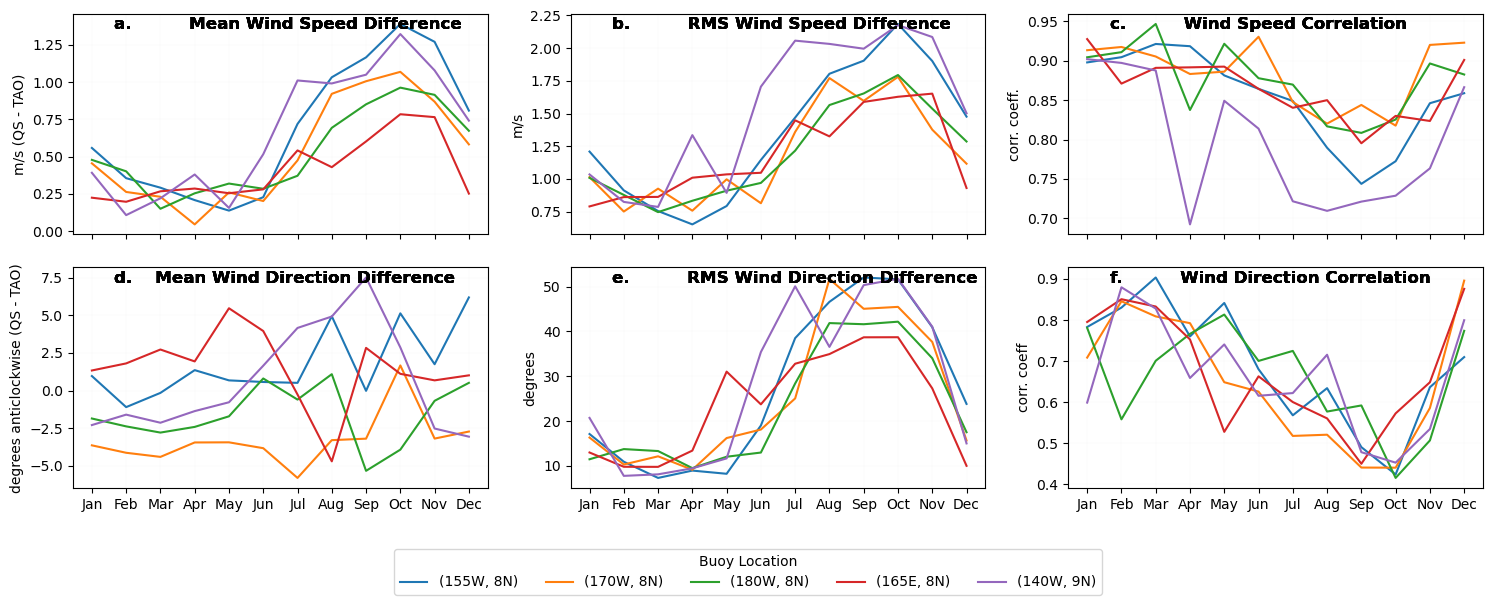

In [38]:
fig, axes  = plt.subplots(nrows = 2, ncols =3, figsize = (15,6), sharex = True)

fontSize = 12

xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

labels = list(this_df['loc'])
ignore_list = ['(125W, 8N)', '(95W, 8N)', '(110W, 8N)']

this_df = speedSeasonalityDF.loc[speedSeasonalityDF['lat'] > 5]
#######################################################################
ax = axes[0,0]
array = np.vstack(this_df['diff'].to_numpy())
figNoAndTitle  = 'a.          Mean Wind Speed Difference'
ylabel = 'm/s (QS - TAO)'

for label, row in zip(labels, array):
    if label not in ignore_list:
        ax.plot(xlabels, row, label = label)
        ax.text(0.1, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        #ax.set_ylim([-0.35, 1.4])
        ax.set_ylabel(ylabel)
        ax.grid(linewidth = 0.1, alpha=0.25)


#######################################################################
ax = axes[0,1]
array = np.vstack(this_df['rmse'].to_numpy())
figNoAndTitle  = 'b.          RMS Wind Speed Difference'
ylabel = 'm/s'

for label, row in zip(labels, array):
    if label not in ignore_list:
        ax.plot(xlabels, row, label = label)
        ax.text(0.1, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        #ax.set_ylim([-0.35, 1.4])
        ax.set_ylabel(ylabel)
        ax.grid(linewidth = 0.1, alpha=0.25)


#######################################################################
ax = axes[0,2]
array = np.vstack(this_df['corr'].to_numpy())
figNoAndTitle  = 'c.          Wind Speed Correlation'
ylabel = 'corr. coeff.'

for label, row in zip(labels, array):
    if label not in ignore_list:
        ax.plot(xlabels, row, label = label)
        ax.text(0.1, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        #ax.set_ylim([-0.35, 1.4])
        ax.set_ylabel(ylabel)
        ax.grid(linewidth = 0.1, alpha=0.25)

#######################################################################
#######################################################################
#######################################################################


this_df = dirSeasonalityDF.loc[speedSeasonalityDF['lat'] > 5]
#######################################################################
ax = axes[1,0]
array = np.vstack(this_df['diff'].to_numpy())
figNoAndTitle  = 'd.    Mean Wind Direction Difference'
ylabel = 'degrees anticlockwise (QS - TAO)'

for label, row in zip(labels, array):
    if label not in ignore_list:
        ax.plot(xlabels, row, label = label)
        ax.text(0.1, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        #ax.set_ylim([-0.35, 1.4])
        ax.set_ylabel(ylabel)
        ax.grid(linewidth = 0.1, alpha=0.25)


#######################################################################
ax = axes[1,1]
array = np.vstack(this_df['rmse'].to_numpy())
figNoAndTitle  = 'e.          RMS Wind Direction Difference'
ylabel = 'degrees'

for label, row in zip(labels, array):
    if label not in ignore_list:
        ax.plot(xlabels, row, label = label)
        ax.text(0.1, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        #ax.set_ylim([-0.35, 1.4])
        ax.set_ylabel(ylabel)
        ax.grid(linewidth = 0.1, alpha=0.25)


#######################################################################
ax = axes[1,2]
array = np.vstack(this_df['corr'].to_numpy())
figNoAndTitle  = 'f.          Wind Direction Correlation'
ylabel = 'corr. coeff'

for label, row in zip(labels, array):
    if label not in ignore_list:
        ax.plot(xlabels, row, label = label)
        ax.text(0.1, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        #ax.set_ylim([-0.35, 1.4])
        ax.set_ylabel(ylabel)
        ax.grid(linewidth = 0.1, alpha=0.25)

######################################################################

# 🌟 Add a single common legend
handles, labels = axes[0, 0].get_legend_handles_labels()  # or gather from multiple if needed
fig.legend(handles, labels, loc='lower center', title='Buoy Location', ncol=len(labels), bbox_to_anchor=(0.5, 0.01))

plt.subplots_adjust(left=0.05, right = 0.99, top=0.99, bottom = 0.2, wspace=0.20, hspace=0.15)
plt.savefig('Frozen_Seasonality.pdf', dpi=100)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='mean_3month_var_of_normalized_RMSE', ylabel='Density'>

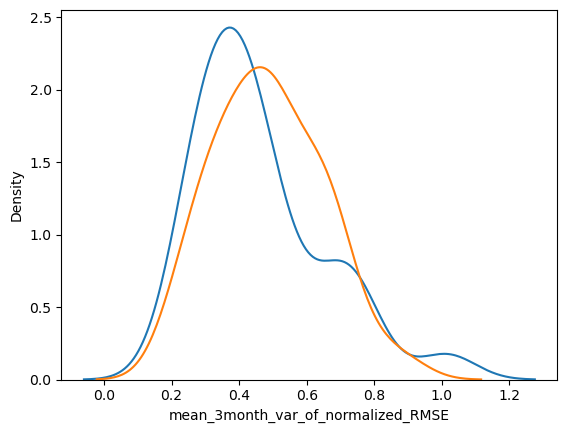

In [39]:
sns.kdeplot(dirSeasonalityDF['mean_3month_var_of_normalized_RMSE'])
sns.kdeplot(speedSeasonalityDF['mean_3month_var_of_normalized_RMSE'])

In [40]:
goodSpeedSeason = speedSeasonalityDF.loc[dirSeasonalityDF['mean_3month_var_of_normalized_RMSE'] < 0.4]
goodDirSeason = dirSeasonalityDF.loc[dirSeasonalityDF['mean_3month_var_of_normalized_RMSE'] < 0.4]

In [41]:
# Group by season using max_diff_month
offset = -1
months = np.roll(np.arange(12), -offset)

winter = months[0:3]
spring = months[3:6]
summer = months[6:9]
fall = months[9:12]
print(winter)
print(spring)
print(summer)
print(fall)
#selectingDF = speedSeasonalityDF.copy()
#selectingDF = goodSpeedSeason.copy()
selectingDF = goodDirSeason.copy()

# winter_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['max_rmse_month'].isin(winter)]#  & selectingDF['min_rmse_month'].isin(summer)   ]
# spring_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['max_rmse_month'].isin(spring)]#   & selectingDF['min_rmse_month'].isin(fall)  ]
# summer_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['max_rmse_month'].isin(summer)]#   & selectingDF['min_rmse_month'].isin(winter)  ]
# fall_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['max_rmse_month'].isin(fall) ] #& selectingDF['min_rmse_month'].isin(spring)   ]


# winter_peak_dir_rmse = goodDirSeason.loc[selectingDF['max_rmse_month'].isin(winter)]#   & selectingDF['min_rmse_month'].isin(summer)]
# spring_peak_dir_rmse = goodDirSeason.loc[selectingDF['max_rmse_month'].isin(spring)]#    & selectingDF['min_rmse_month'].isin(fall)]
# summer_peak_dir_rmse = goodDirSeason.loc[selectingDF['max_rmse_month'].isin(summer)]#    & selectingDF['min_rmse_month'].isin(winter)]
# fall_peak_dir_rmse = goodDirSeason.loc[selectingDF['max_rmse_month'].isin(fall)] #  & selectingDF['min_rmse_month'].isin(spring)]


winter_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['min_rmse_month'].isin(winter)]#  & selectingDF['min_rmse_month'].isin(summer)   ]
spring_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['min_rmse_month'].isin(spring)]#   & selectingDF['min_rmse_month'].isin(fall)  ]
summer_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['min_rmse_month'].isin(summer)]#   & selectingDF['min_rmse_month'].isin(winter)  ]
fall_peak_speed_rmse = goodSpeedSeason.loc[selectingDF['min_rmse_month'].isin(fall) ] #& selectingDF['min_rmse_month'].isin(spring)   ]


winter_peak_dir_rmse = goodDirSeason.loc[selectingDF['min_rmse_month'].isin(winter)]#   & selectingDF['min_rmse_month'].isin(summer)]
spring_peak_dir_rmse = goodDirSeason.loc[selectingDF['min_rmse_month'].isin(spring)]#    & selectingDF['min_rmse_month'].isin(fall)]
summer_peak_dir_rmse = goodDirSeason.loc[selectingDF['min_rmse_month'].isin(summer)]#    & selectingDF['min_rmse_month'].isin(winter)]
fall_peak_dir_rmse = goodDirSeason.loc[selectingDF['min_rmse_month'].isin(fall)] #  & selectingDF['min_rmse_month'].isin(spring)]

[11  0  1]
[2 3 4]
[5 6 7]
[ 8  9 10]


In [42]:
for i in range(54):
    if dirSeasonalityDF.iloc[i]['max_rmse_month']  == 0:
        print(dirSeasonalityDF.iloc[i]['loc'], dirSeasonalityDF.iloc[i]['max_rmse_month'])
        print(dirSeasonalityDF.iloc[i]['rmse'])

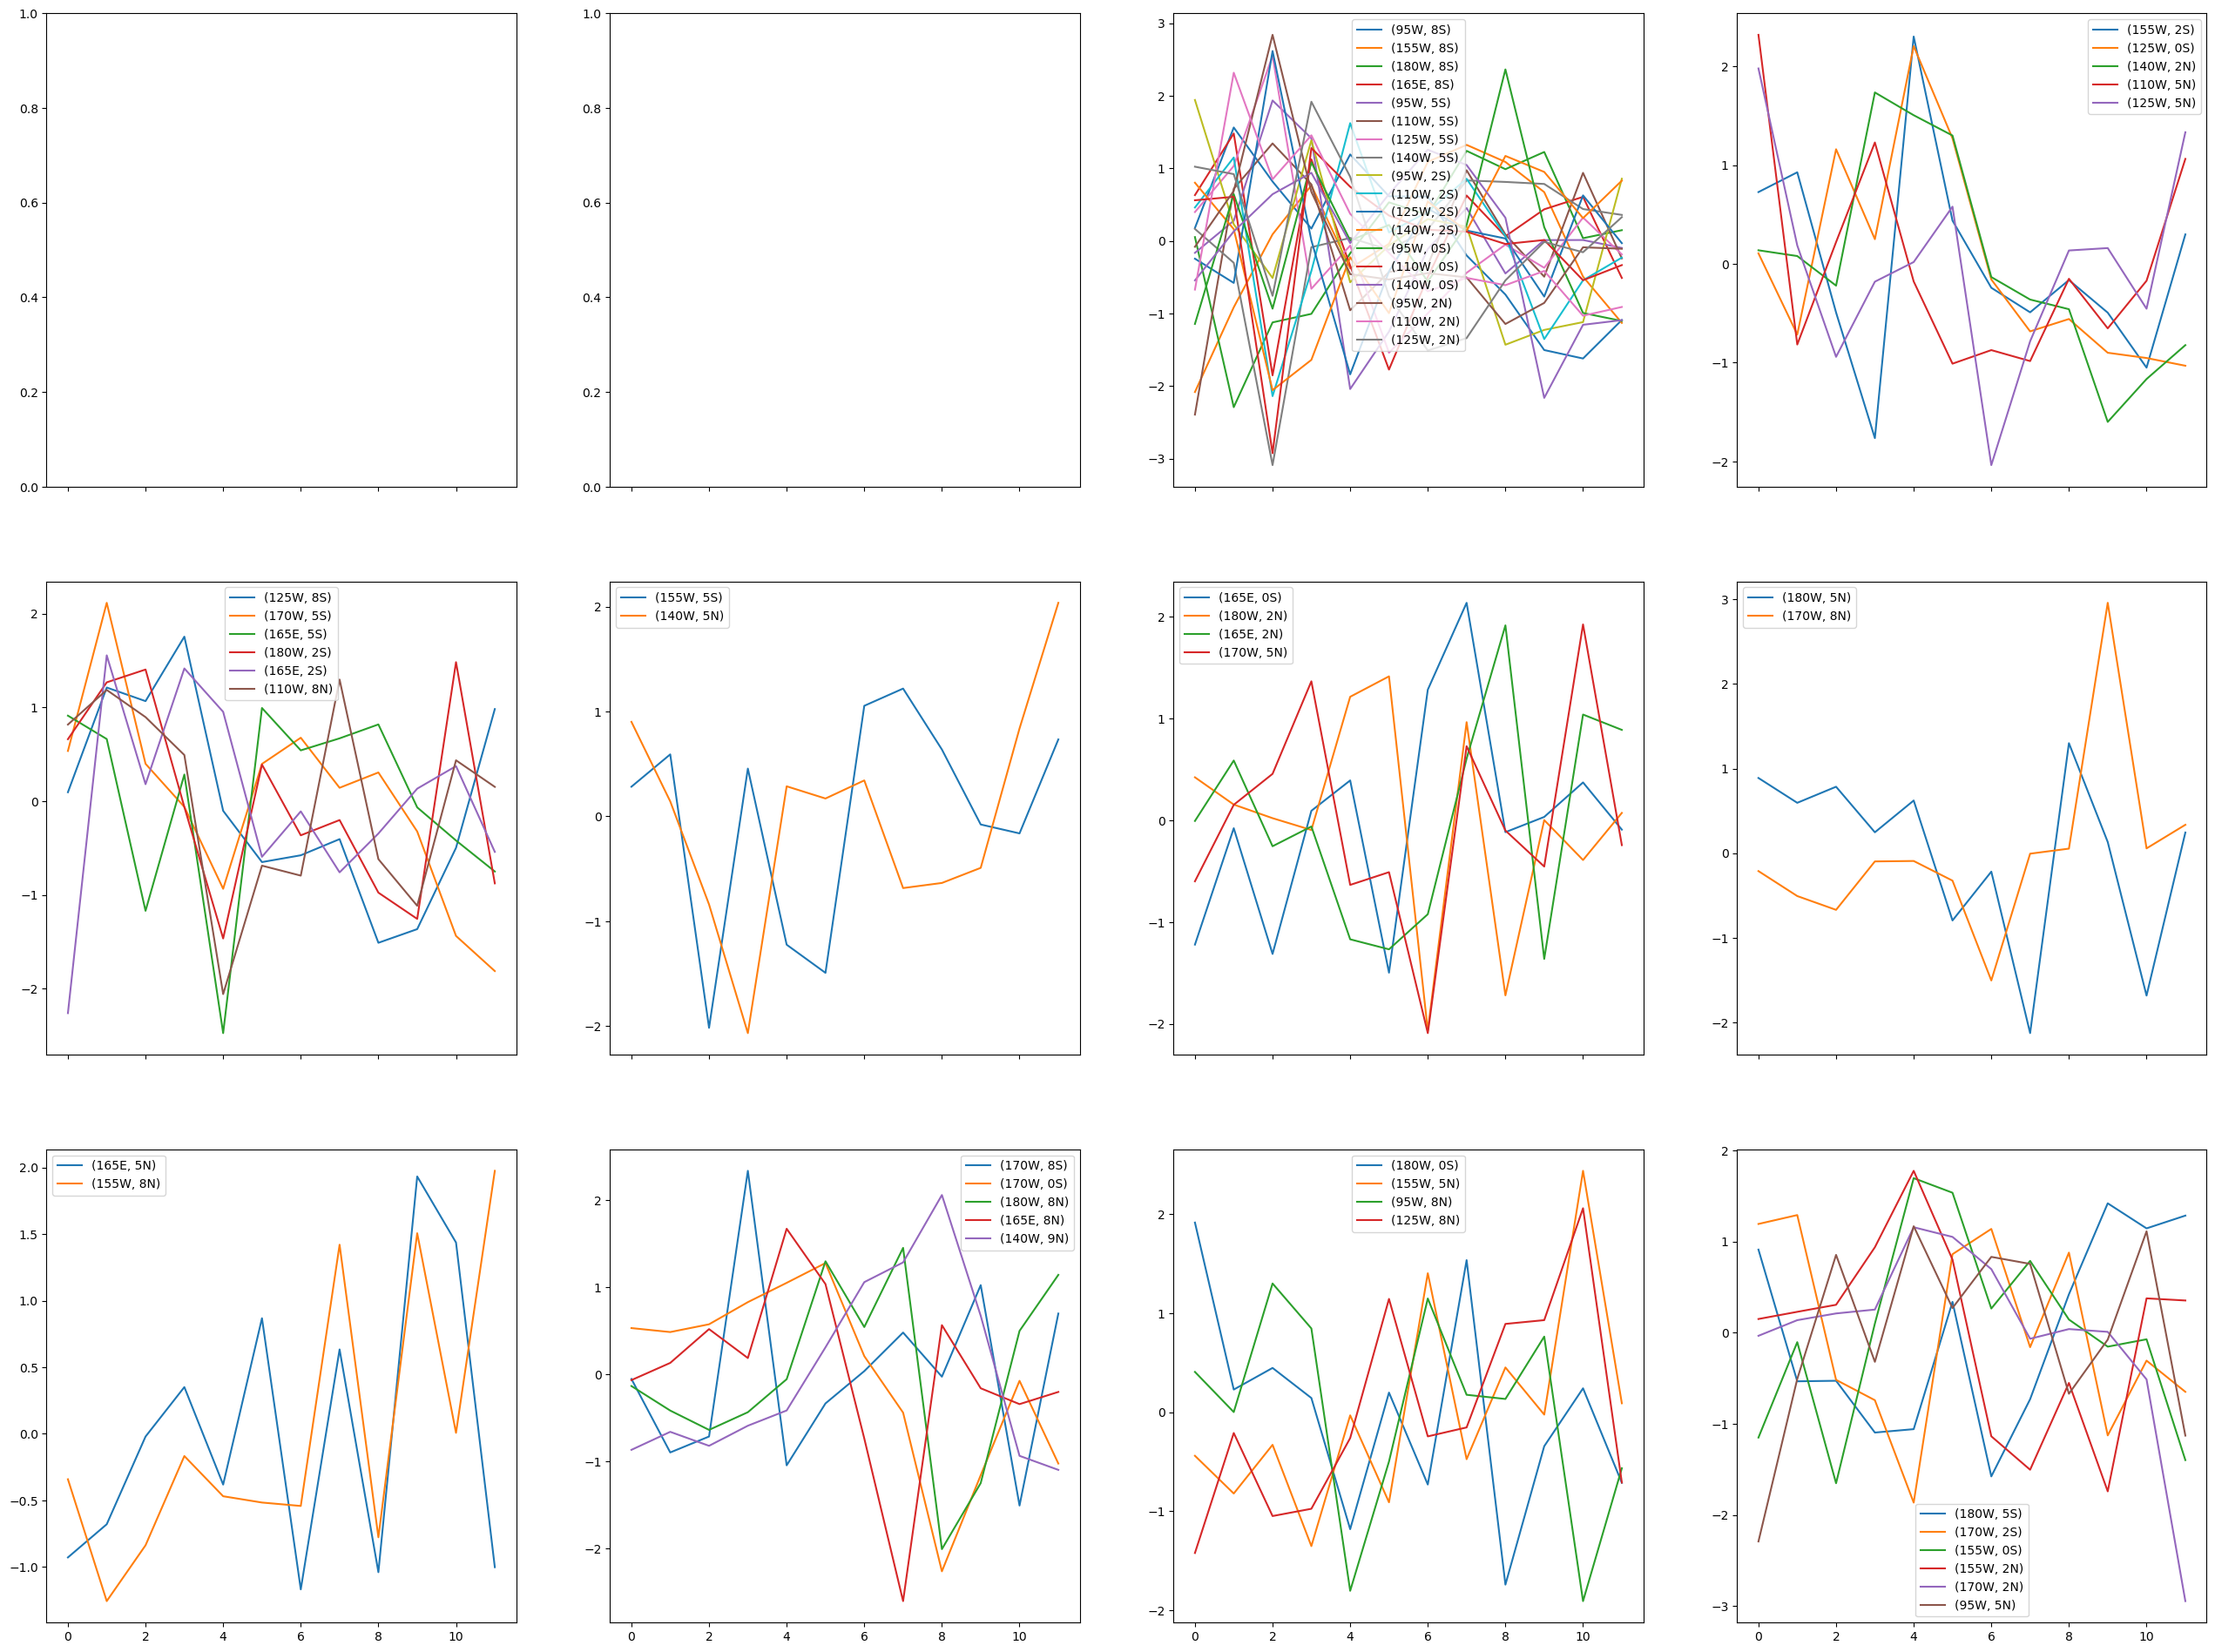

In [43]:
fig, axes  = plt.subplots(nrows = 3, ncols =4, figsize = (32,24), sharex = True)

offset = 0#-1
months = np.roll(np.arange(12), -offset)
for i in range(12):
    ax = axes.flatten()[i]
    this_df = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin(months[i:i+1])]
    if len(this_df) > 0:
        array = np.vstack(this_df['diff'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            #if label not in ignore_list:
                ax.plot((row- np.mean(row))/(np.std(row)), label = label)
        ax.legend()

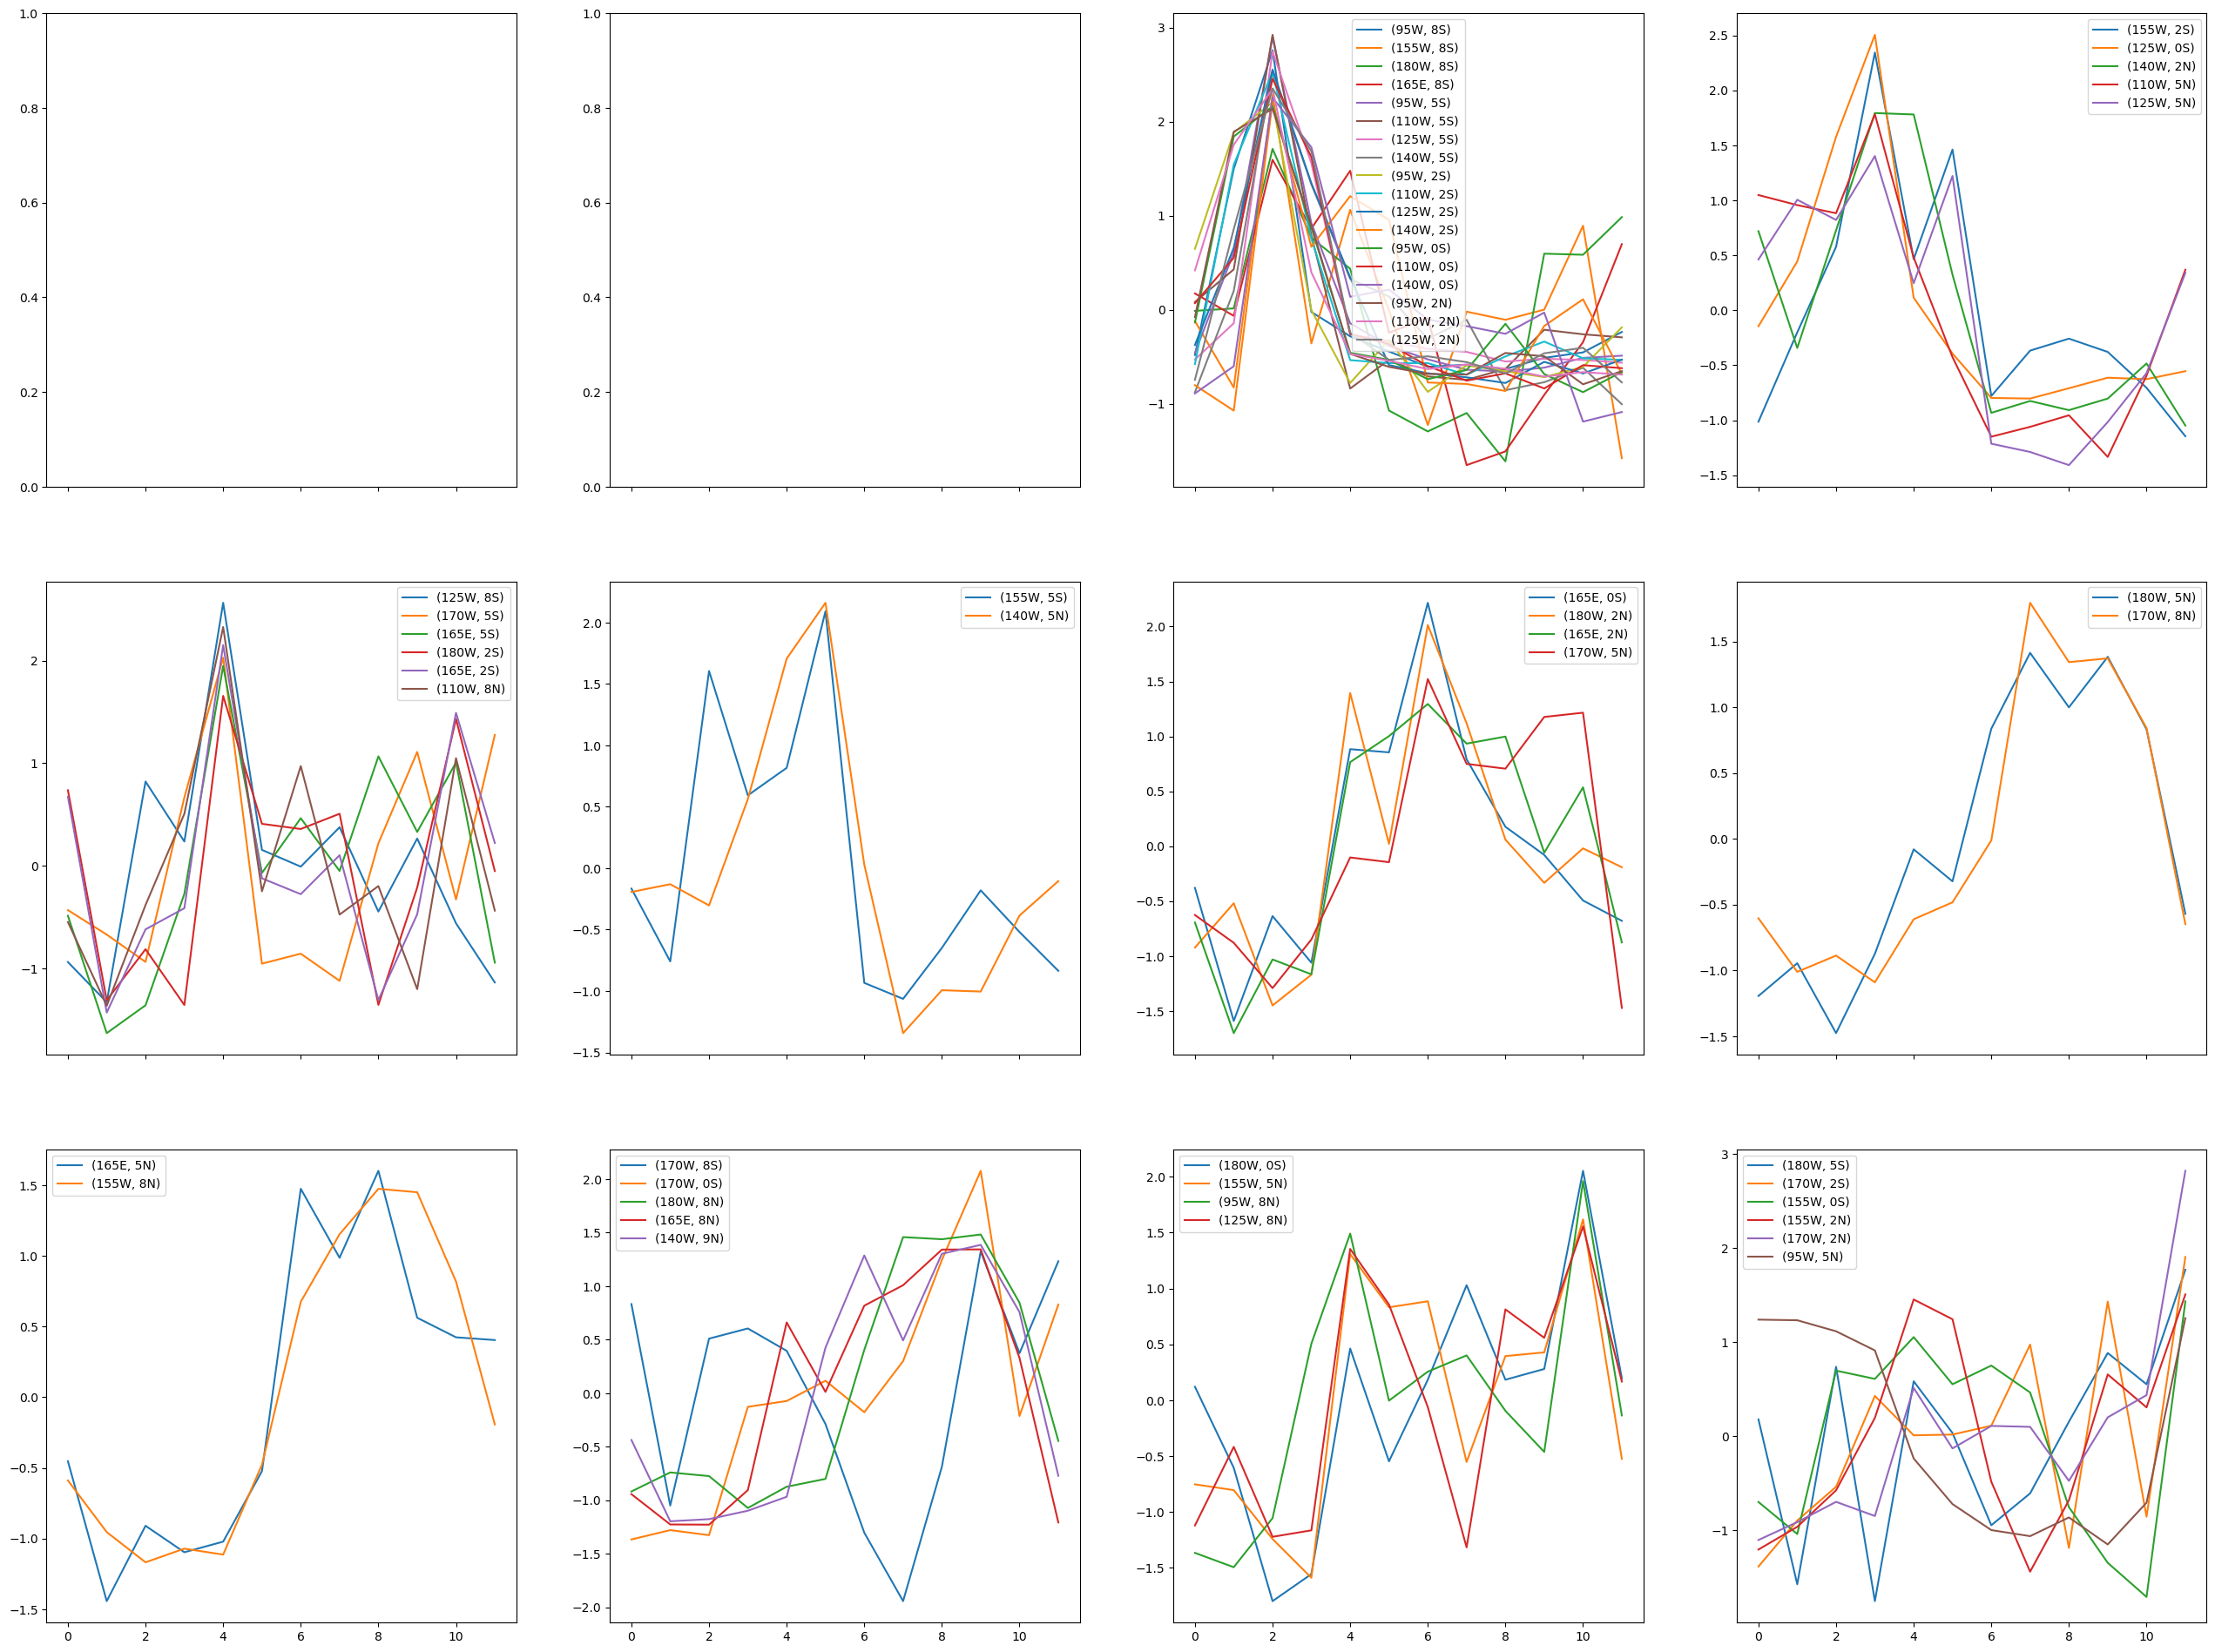

In [44]:
group1 = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([2,3])]
group2 = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([4,5])]
group3 = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([6,7])]
fig, axes  = plt.subplots(nrows = 3, ncols =4, figsize = (32,24), sharex = True)

offset = 0#-1
months = np.roll(np.arange(12), -offset)
for i in range(12):
    ax = axes.flatten()[i]
    this_df = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin(months[i:i+1])]
    if len(this_df) > 0:
        array = np.vstack(this_df['rmse'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            #if label not in ignore_list:
                ax.plot((row- np.mean(row))/(np.std(row)), label = label)
        ax.legend()
    

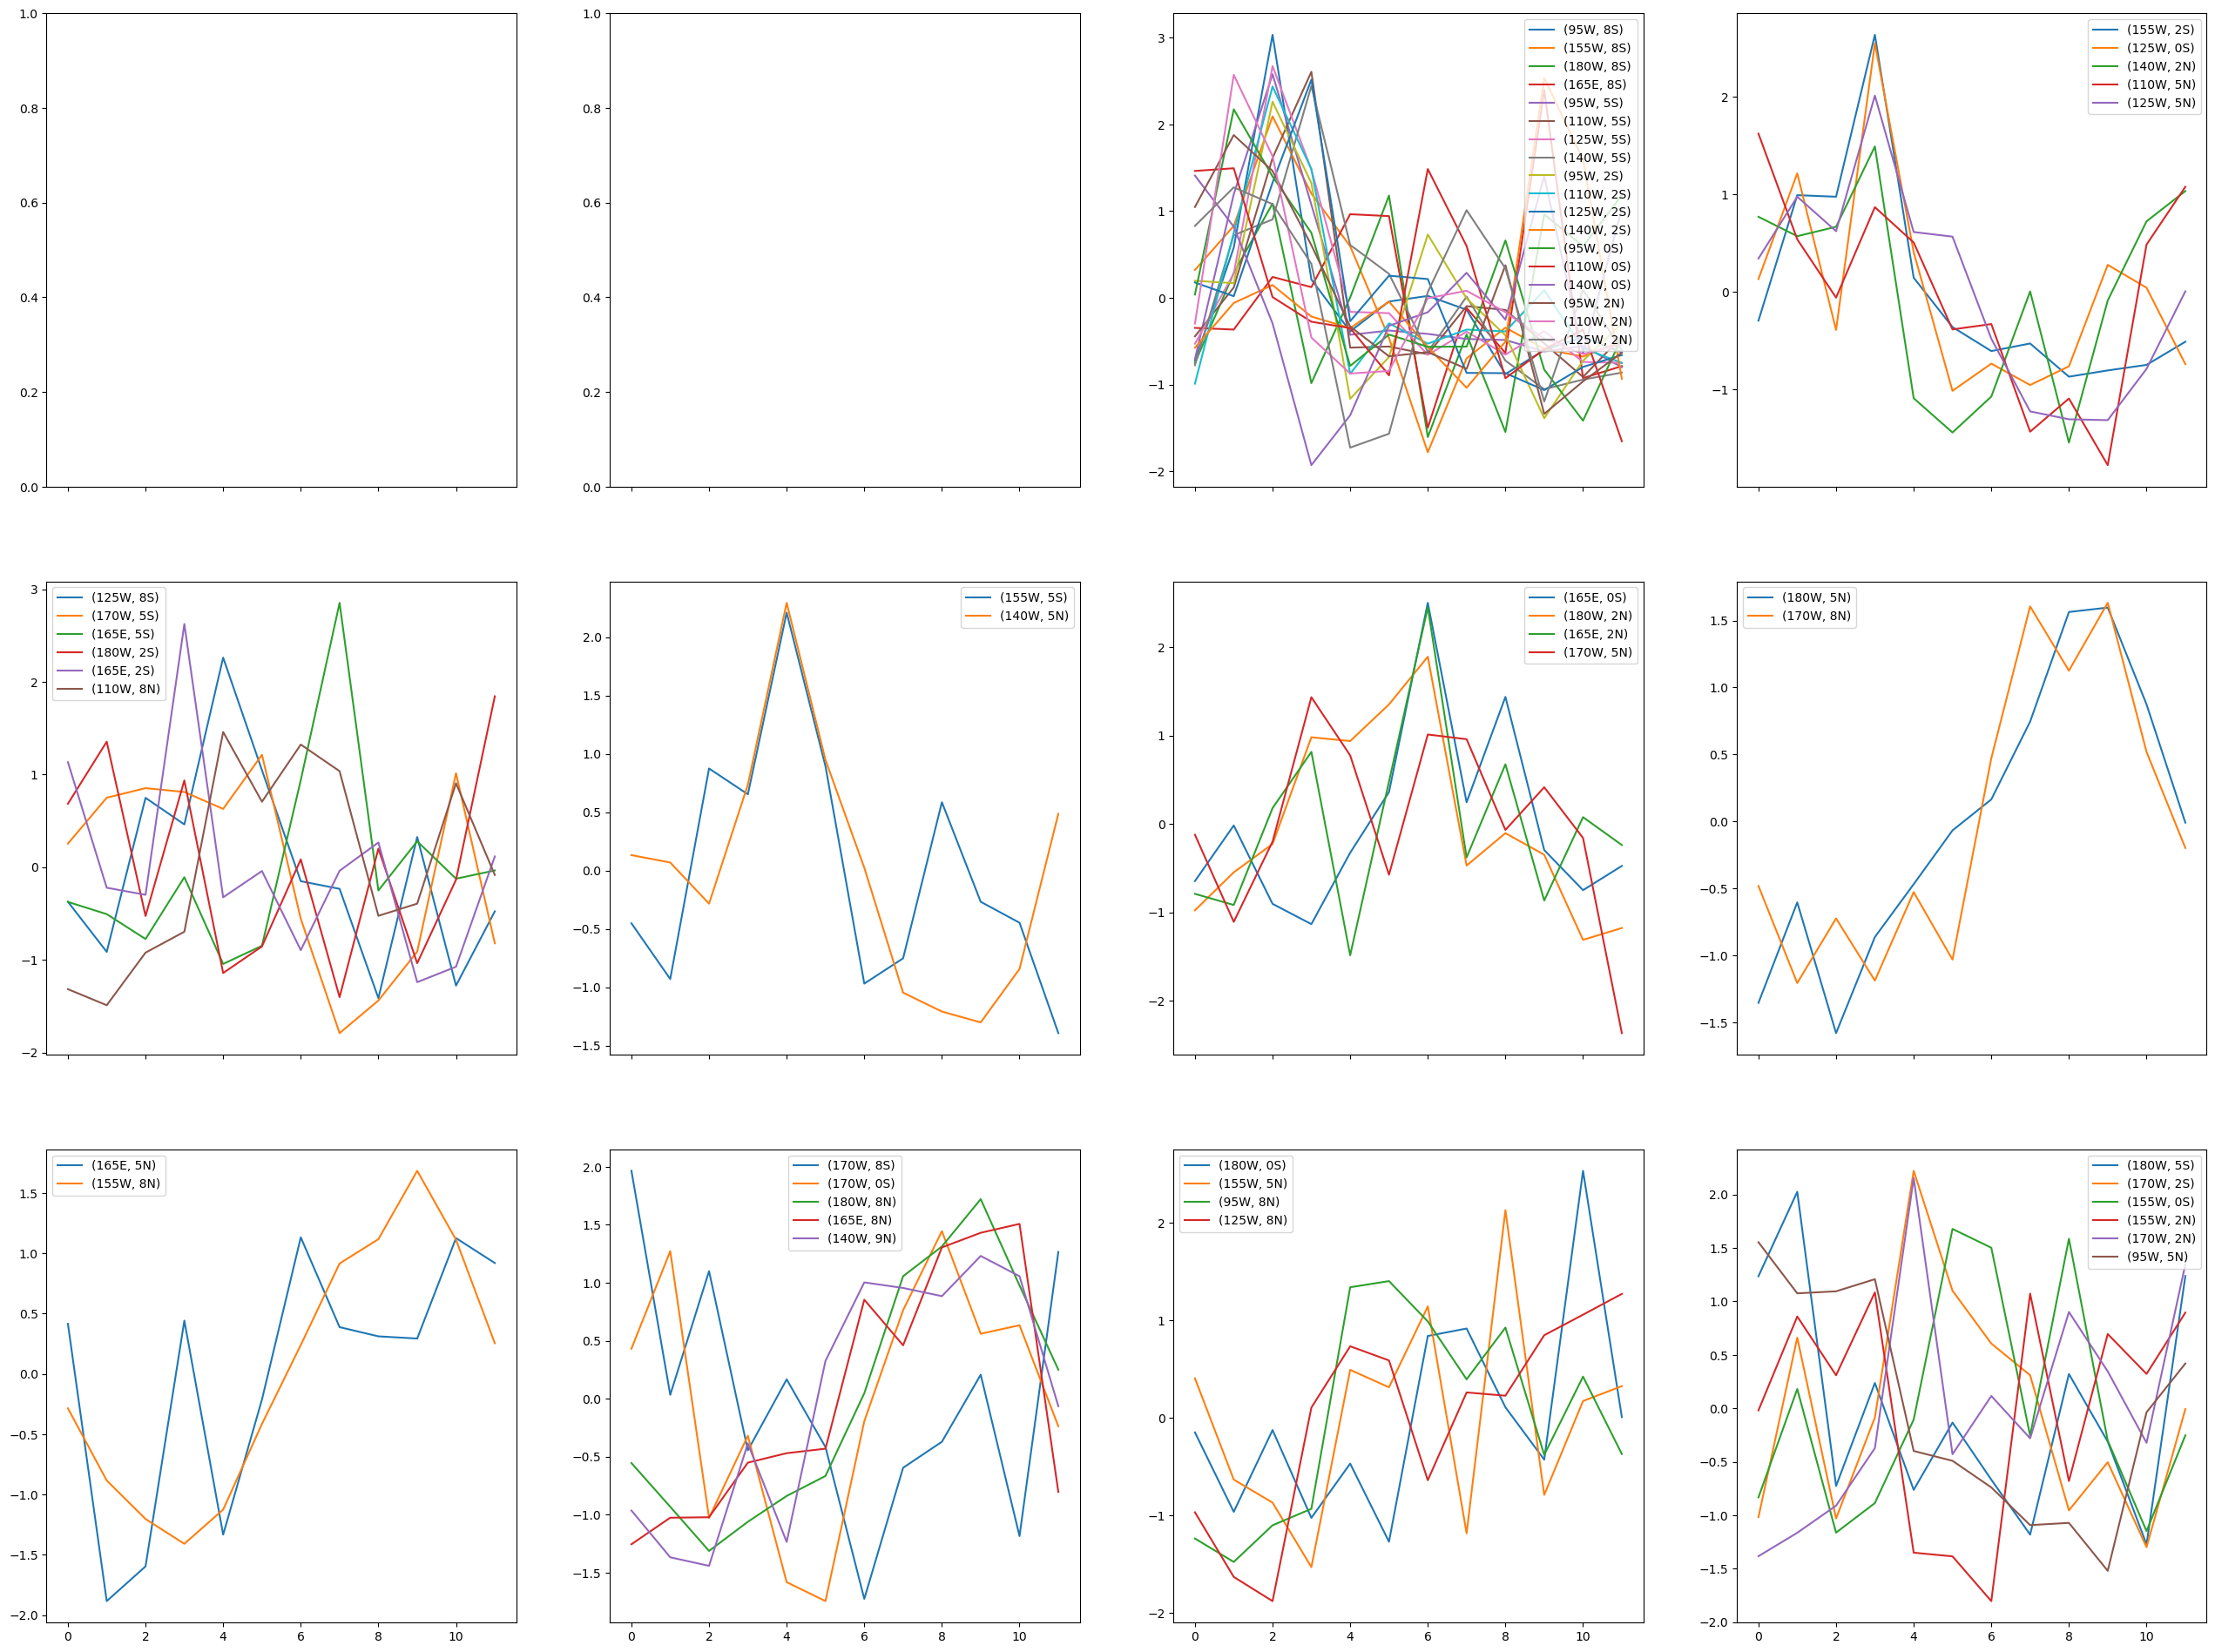

In [45]:
fig, axes  = plt.subplots(nrows = 3, ncols =4, figsize = (32,24), sharex = True)

offset = 0#-1
months = np.roll(np.arange(12), -offset)
for i in range(12):
    ax = axes.flatten()[i]
    this_df = speedSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin(months[i:i+1])]
    if len(this_df) > 0:
        array = np.vstack(this_df['rmse'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            #if label not in ignore_list:
                ax.plot((row- np.mean(row))/(np.std(row)), label = label)
        ax.legend()

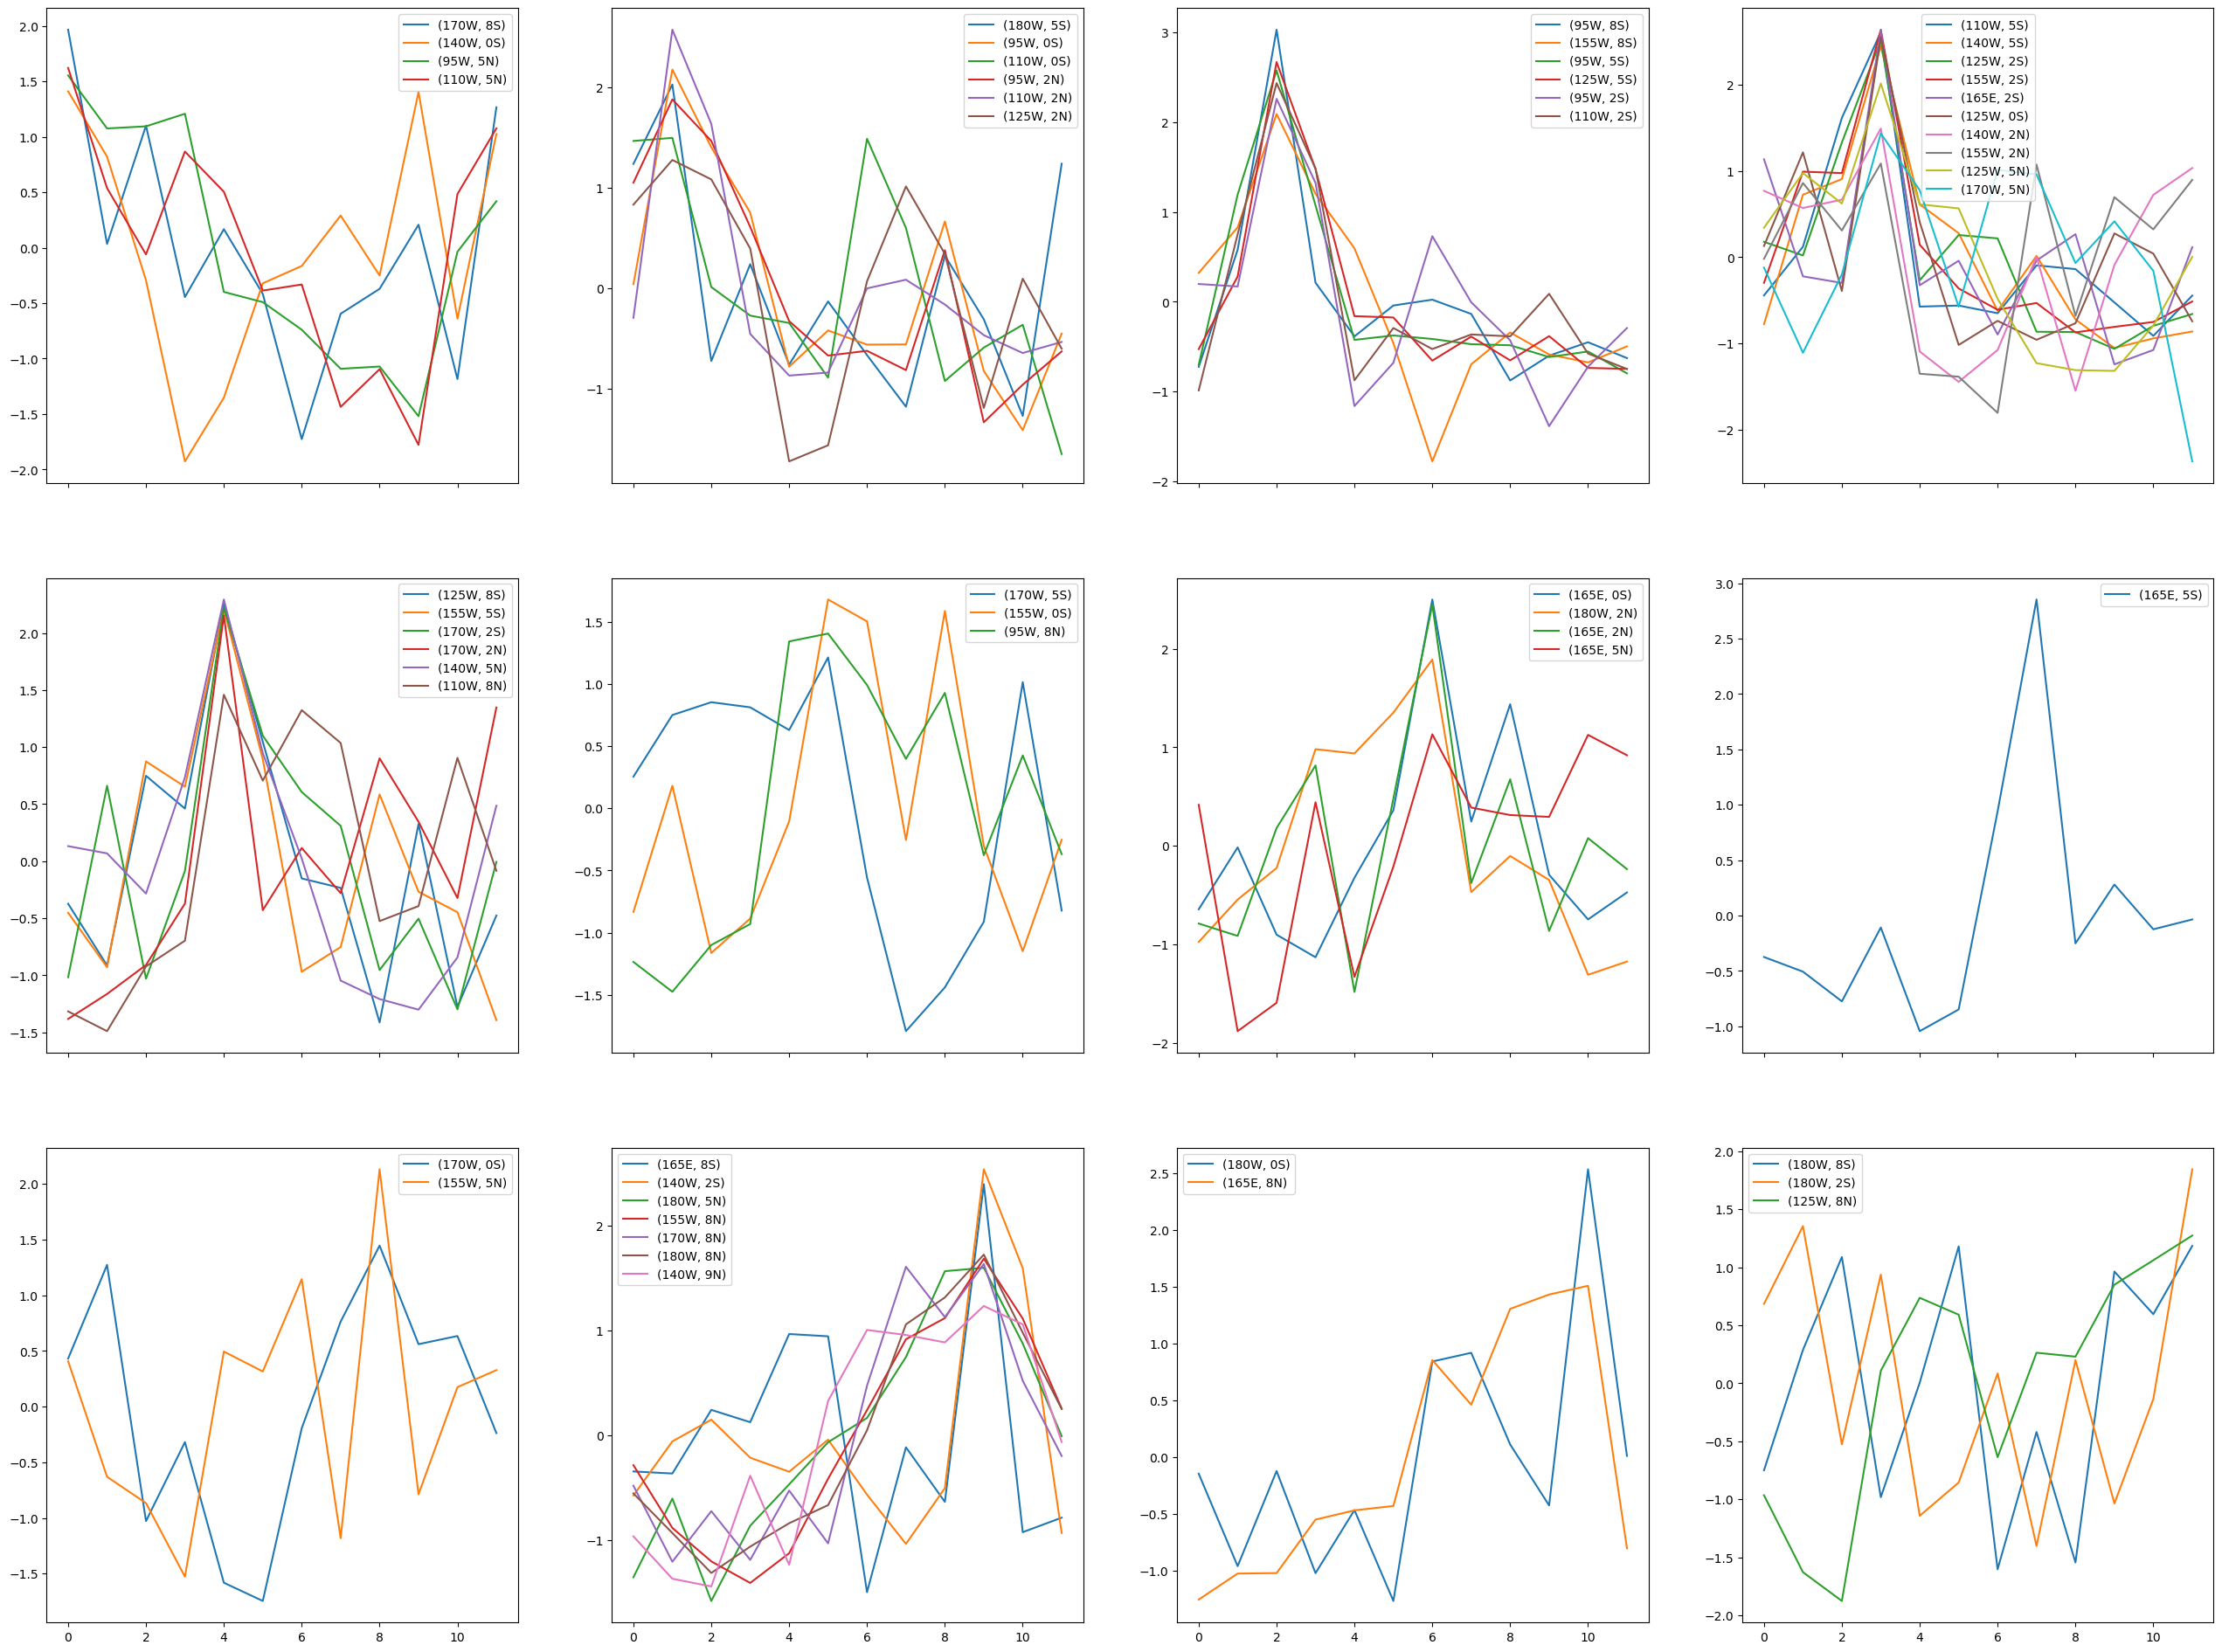

In [46]:
fig, axes  = plt.subplots(nrows = 3, ncols =4, figsize = (32,24), sharex = True)

offset = 0#-1
months = np.roll(np.arange(12), -offset)
for i in range(12):
    ax = axes.flatten()[i]
    this_df = speedSeasonalityDF.loc[speedSeasonalityDF['max_rmse_month'].isin(months[i:i+1])]
    if len(this_df) > 0:
        array = np.vstack(this_df['rmse'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            #if label not in ignore_list:
                ax.plot((row- np.mean(row))/(np.std(row)), label = label)
        ax.legend()

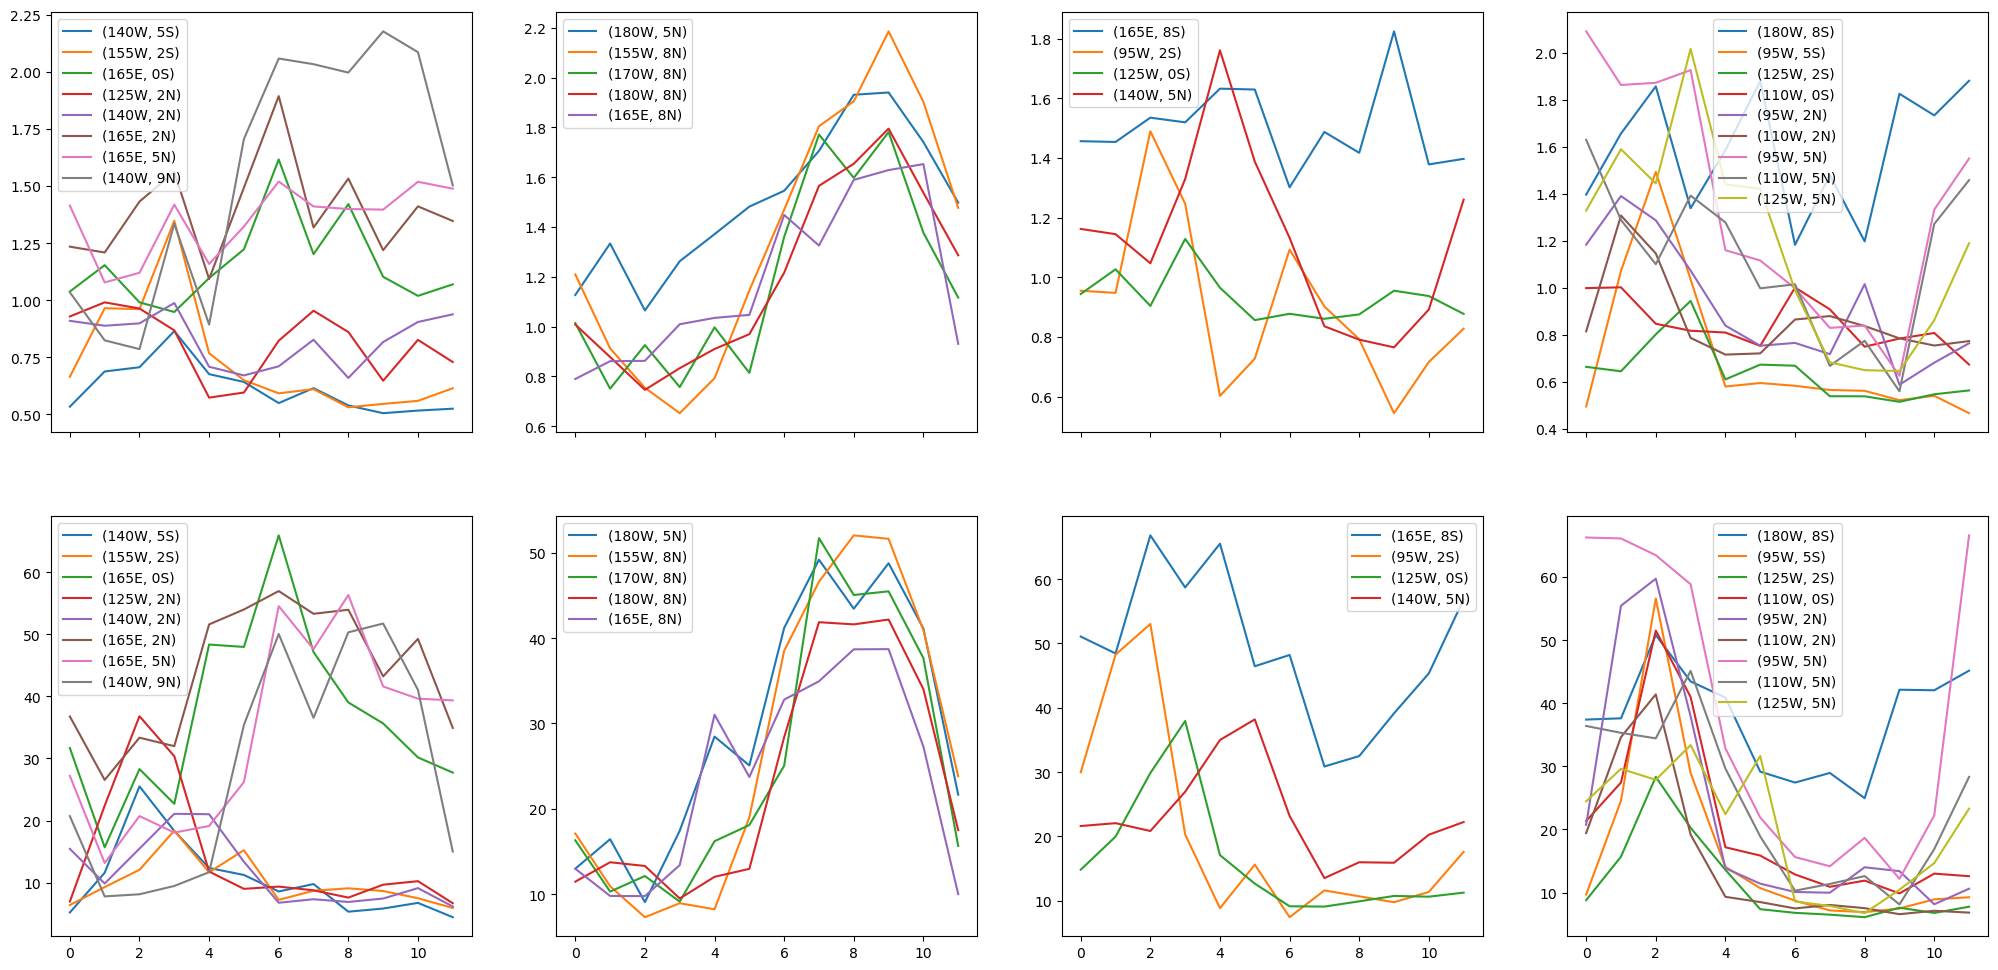

In [47]:
fig, axes  = plt.subplots(nrows = 2, ncols =4, figsize = (25,12), sharex = True)

ax = axes[0, 0]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = winter_peak_speed_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        #if label not in ignore_list:
            ax.plot(row, label = label)
    ax.legend()

ax = axes[0, 1]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = spring_peak_speed_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        #if label not in ignore_list:
            ax.plot(row, label = label)
    ax.legend()

ax = axes[0, 2]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = summer_peak_speed_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        #if label not in ignore_list:
            ax.plot(row, label = label)
    ax.legend()

ax = axes[0, 3]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = fall_peak_speed_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        if label not in ignore_list:
            ax.plot(row, label = label)
    ax.legend()


ax = axes[1, 0]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = winter_peak_dir_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        #if label not in ignore_list:
            ax.plot(row, label = label)
    ax.legend()

ax = axes[1, 1]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = spring_peak_dir_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        #if label not in ignore_list:
            ax.plot(row, label = label)
    ax.legend()

ax = axes[1, 2]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = summer_peak_dir_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        #if label not in ignore_list:
            ax.plot(row, label = label)
    ax.legend()

ax = axes[1, 3]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = fall_peak_dir_rmse
if len(this_df) > 0:
    array = np.vstack(this_df['rmse'].to_numpy())
    labels = list(this_df['loc'])
    
    for label, row in zip(labels, array):
        if label not in ignore_list:
            ax.plot(row, label = label)
    plt.legend()


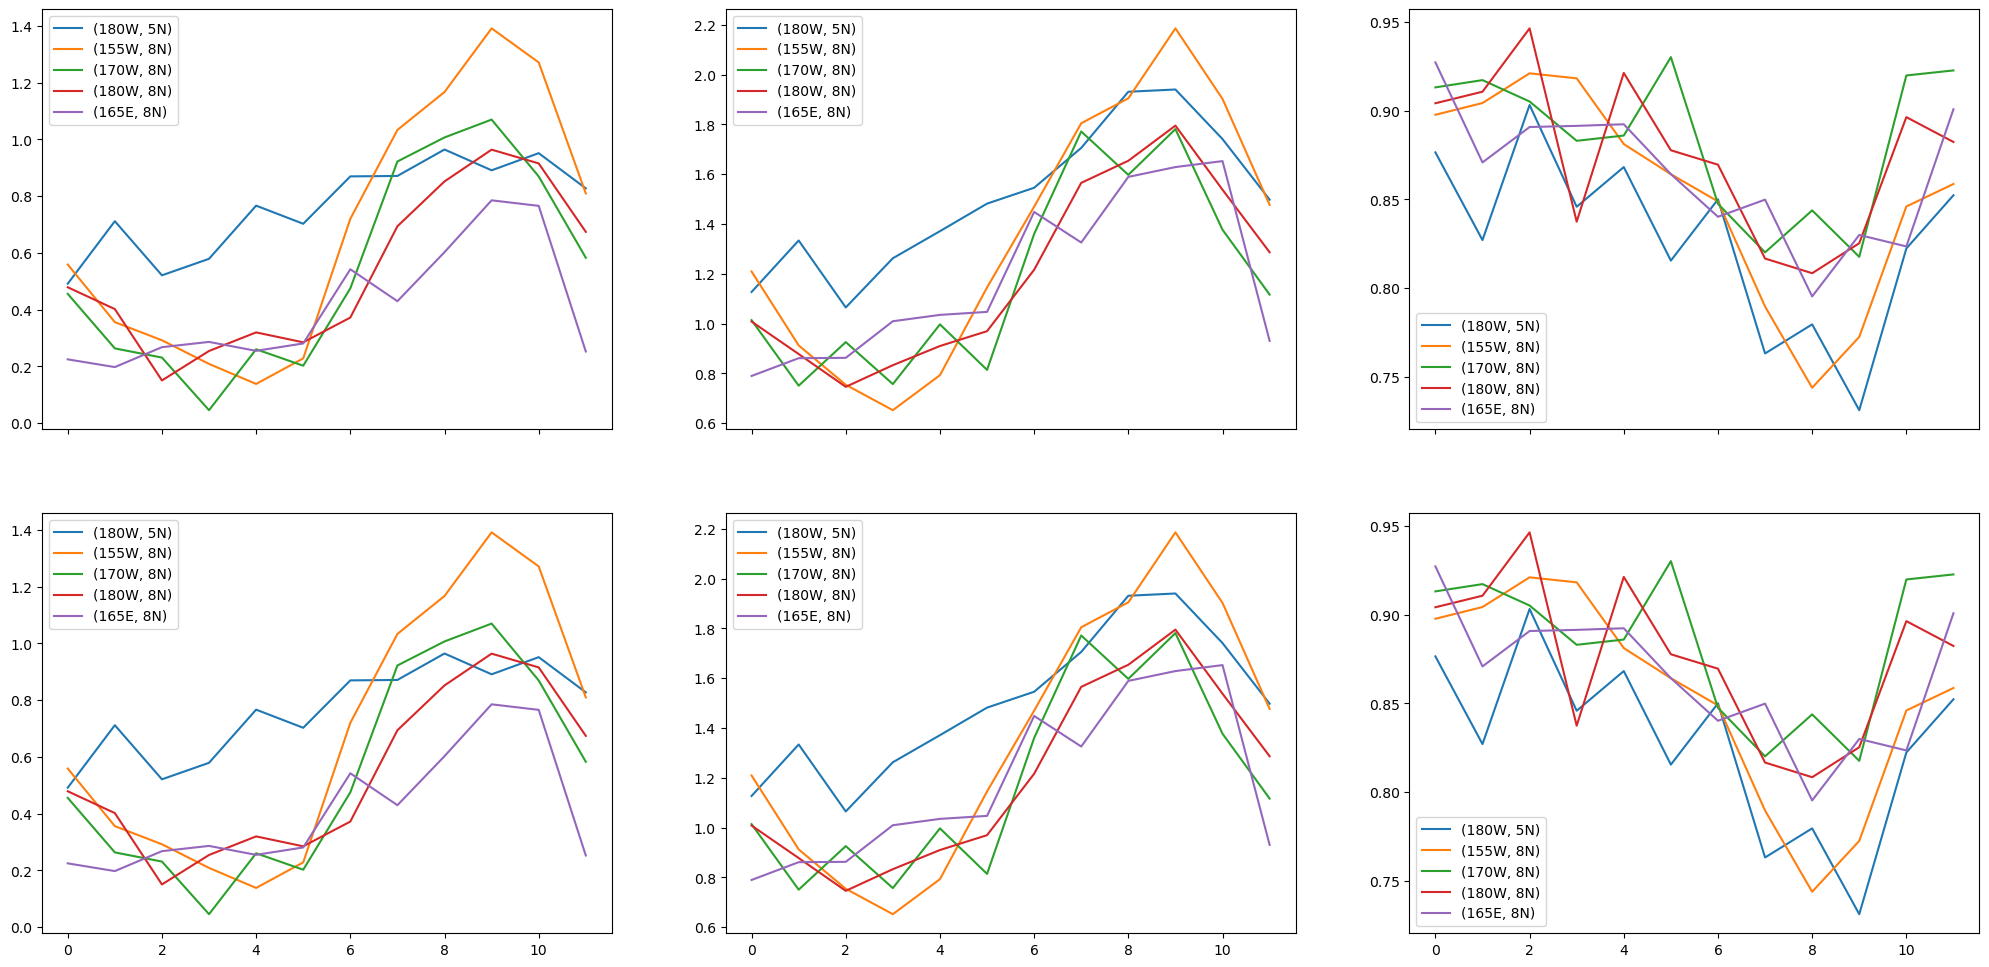

In [48]:
fig, axes  = plt.subplots(nrows = 2, ncols =3, figsize = (25,12), sharex = True)

ax = axes[0, 0]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
this_df = spring_peak_speed_rmse
array = np.vstack(this_df['diff'].to_numpy())
labels = list(this_df['loc'])

for label, row in zip(labels, array):
    #if label not in ignore_list:
        ax.plot(row, label = label)
ax.legend()

ax = axes[0, 1]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
array = np.vstack(this_df['rmse'].to_numpy())
labels = list(this_df['loc'])

for label, row in zip(labels, array):
    #if label not in ignore_list:
        ax.plot(row, label = label)
ax.legend()


ax = axes[0, 2]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
array = np.vstack(this_df['corr'].to_numpy())
labels = list(this_df['loc'])

for label, row in zip(labels, array):
    #if label not in ignore_list:
        ax.plot(row, label = label)
ax.legend()

ax = axes[1, 0]
array = np.vstack(this_df['diff'].to_numpy())
labels = list(this_df['loc'])

for label, row in zip(labels, array):
    #if label not in ignore_list:
        ax.plot(row, label = label)
ax.legend()

ax = axes[1, 1]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
array = np.vstack(this_df['rmse'].to_numpy())
labels = list(this_df['loc'])

for label, row in zip(labels, array):
    #if label not in ignore_list:
        ax.plot(row, label = label)
ax.legend()


ax = axes[1, 2]
# Convert 'difference' column to a 2D array (n_sites x 12 months)
array = np.vstack(this_df['corr'].to_numpy())
labels = list(this_df['loc'])

for label, row in zip(labels, array):
    #if label not in ignore_list:
        ax.plot(row, label = label)
ax.legend()



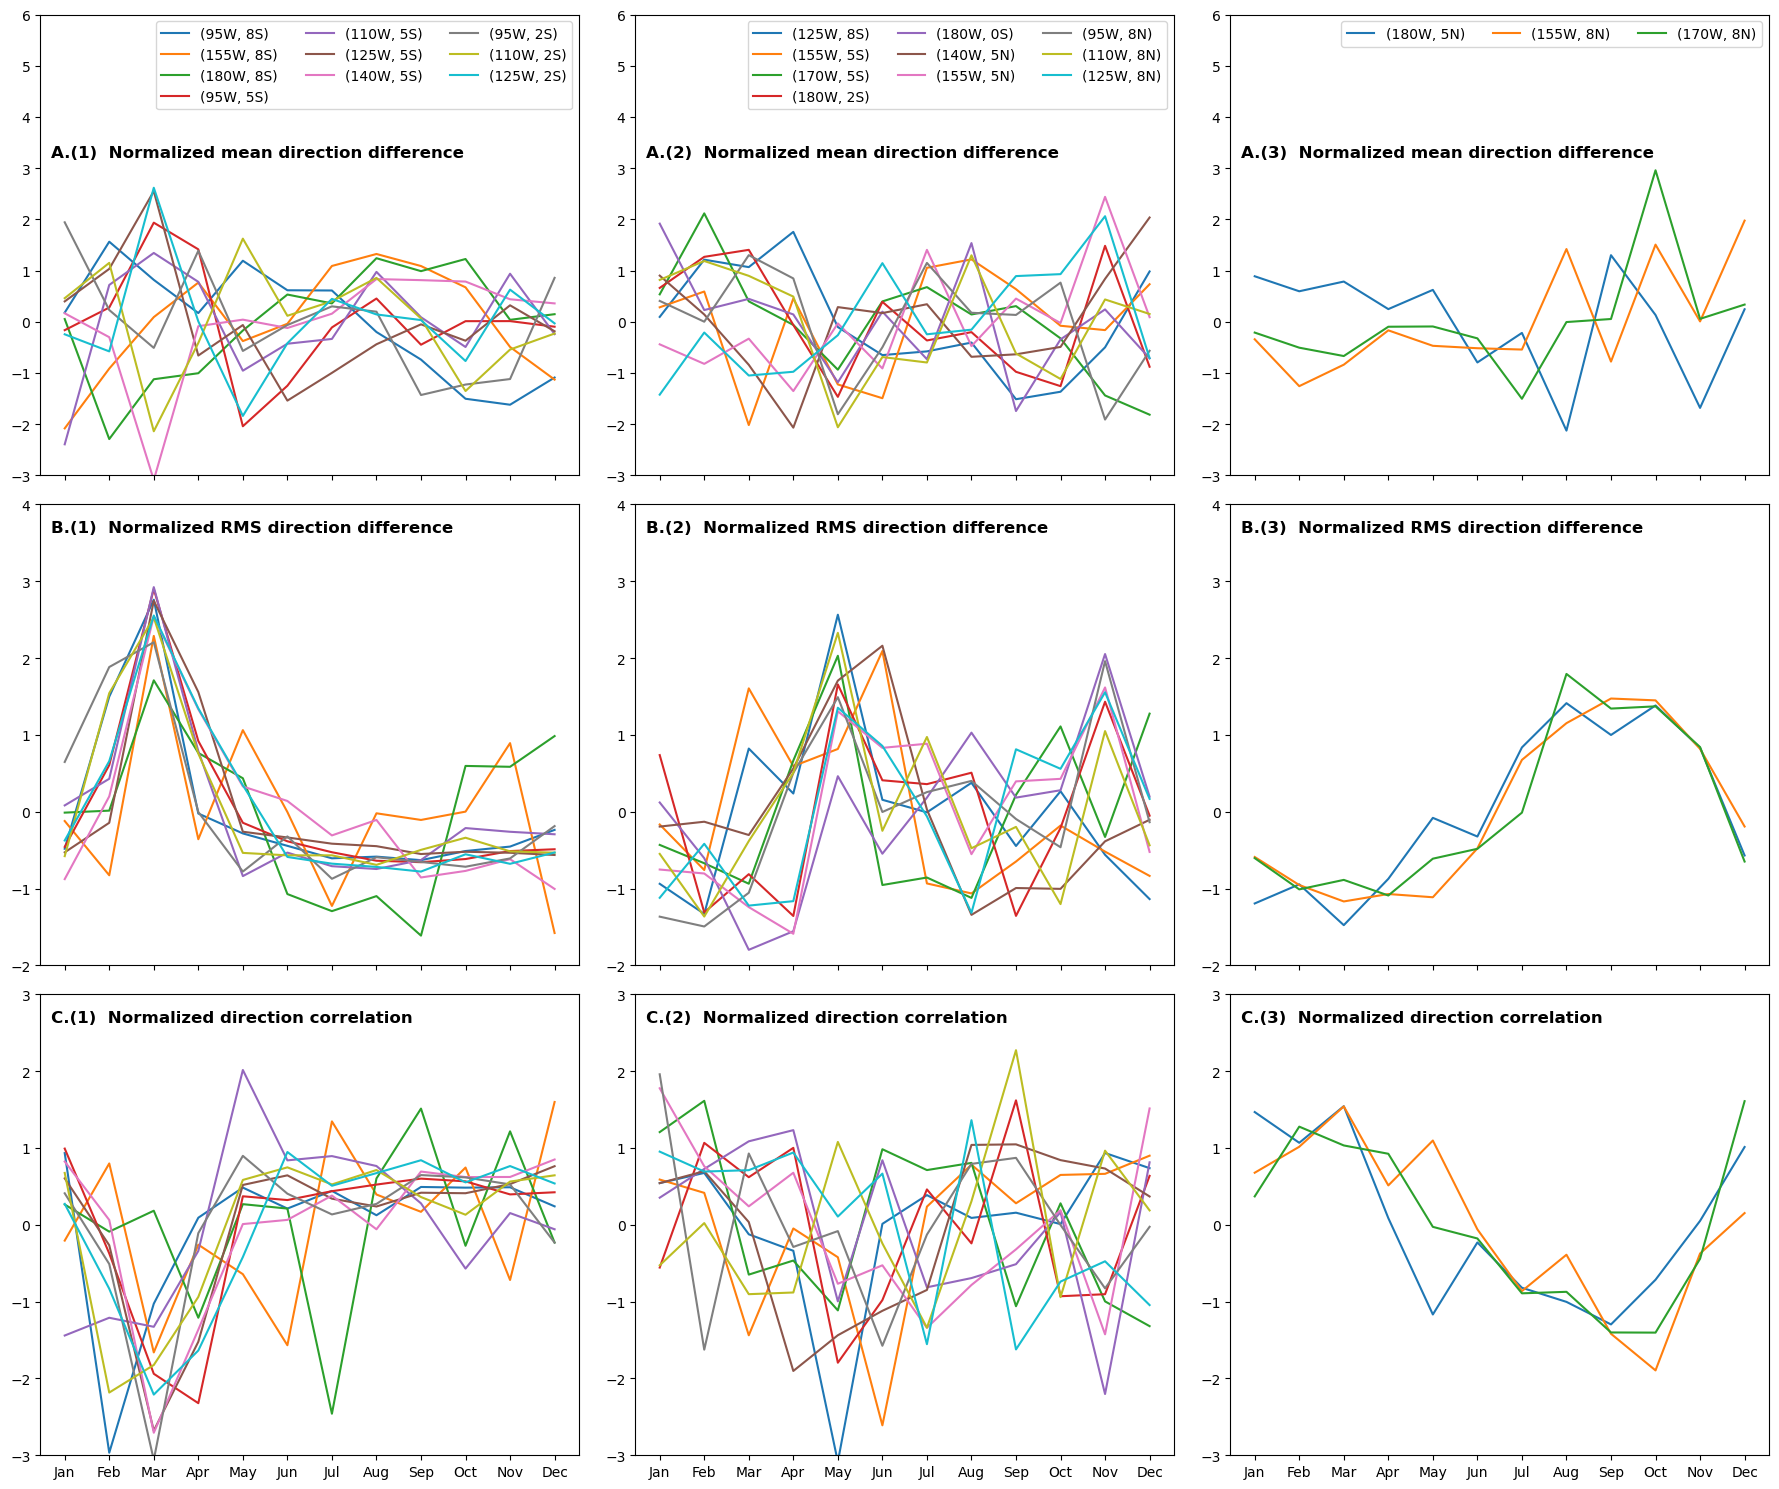

In [49]:
group1 = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([2])]
group2 = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([4,5,10])]
group3 = dirSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([6,7,8])]

groups = [group1, group2, group3]
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

ignore_list = [ '(165E, 5N)',
                '(95W, 2N)', 
                '(110W, 2N)', 
                '(125W, 2N)',
                '(170W, 5N)',
                '(180W, 2N)',
                '(165E, 2N)',
                '(95W, 0S)', 
                '(110W, 0S)', 
                '(140W, 0S)',
                '(165E, 0S)',
                '(140W, 2S)',
                '(165E, 2S)',
                '(165E, 5S)',
                '(165E, 8S)']

fig, axes  = plt.subplots(nrows = 3, ncols =3, sharex = True, sharey= False, figsize = (18,15))

for i in range(3):
    ax = axes[0, i]
    this_df = groups[i]
    if len(this_df) > 0:
        array = np.vstack(this_df['diff'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            if label not in ignore_list:
                ax.plot(xlabels, (row- np.mean(row))/(np.std(row)), label = label)
        ax.legend(ncol = 3)
        figNoAndTitle = f'A.({i+1:d})  Normalized mean direction difference'
        ax.text(0.02, 0.7, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        ax.set_ylim([-3,6])


for i in range(3):
    ax = axes[1, i]
    this_df = groups[i]
    if len(this_df) > 0:
        array = np.vstack(this_df['rmse'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            if label not in ignore_list:
                ax.plot(xlabels, (row- np.mean(row))/(np.std(row)), label = label)
        #ax.legend(ncol = 3)
        figNoAndTitle = f'B.({i+1:d})  Normalized RMS direction difference'
        ax.text(0.02, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        ax.set_ylim([-2,4])


for i in range(3):
    ax = axes[2, i]
    this_df = groups[i]
    if len(this_df) > 0:
        array = np.vstack(this_df['corr'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            if label not in ignore_list:
                ax.plot(xlabels, (row- np.mean(row))/(np.std(row)), label = label)
        #ax.legend(ncol = 3)
        figNoAndTitle = f'C.({i+1:d})  Normalized direction correlation'
        ax.text(0.02, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        ax.set_ylim([-3, 3])

plt.tight_layout()
plt.savefig('Frozen_directionSeasonality.pdf', dpi=100)

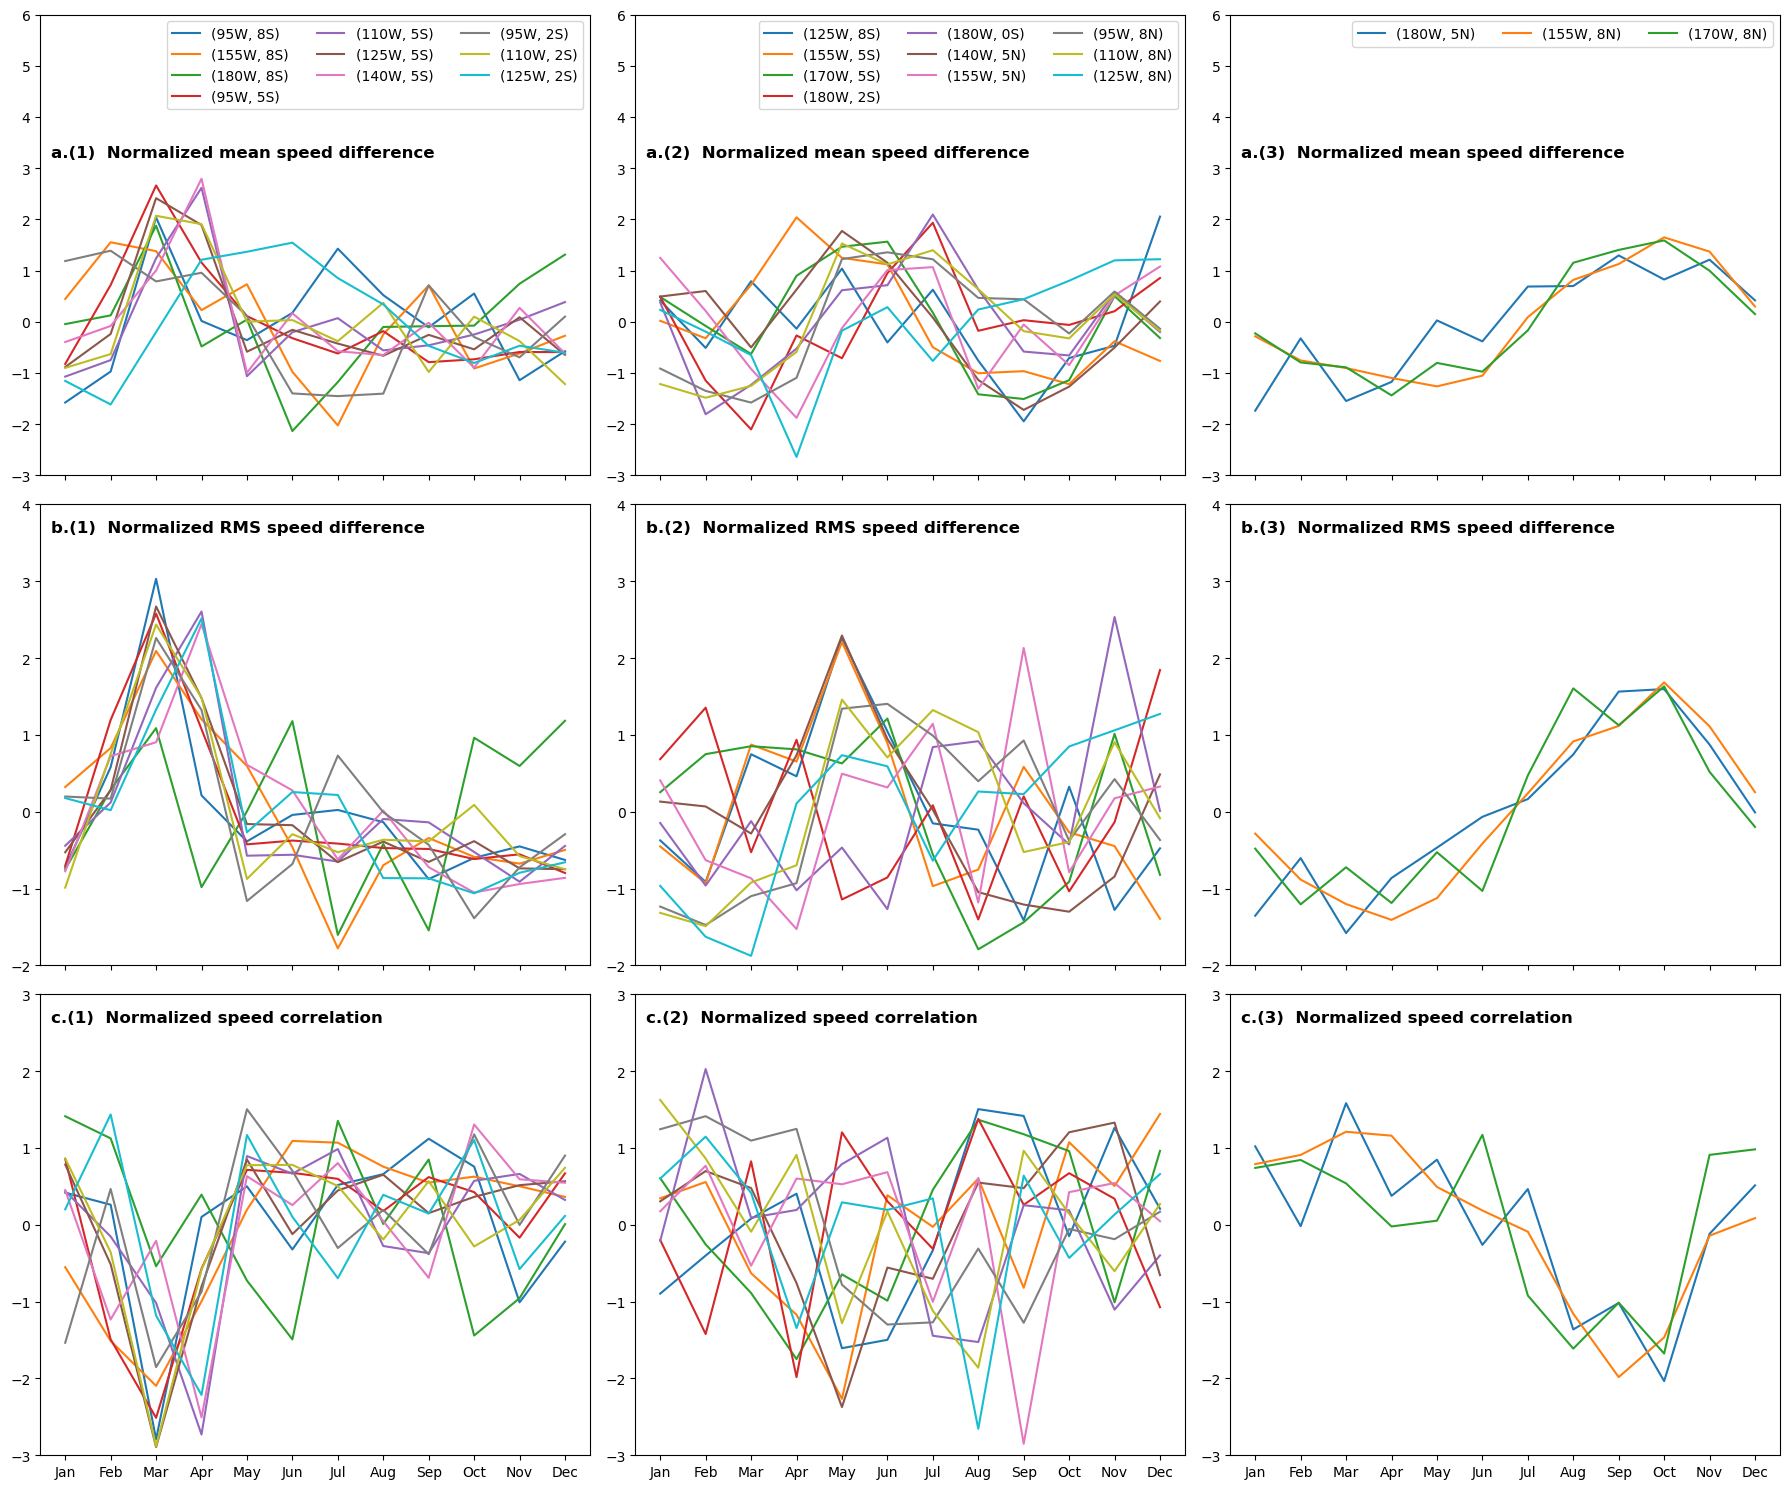

In [50]:
group1 = speedSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([2])]
group2 = speedSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([4,5,10])]
group3 = speedSeasonalityDF.loc[dirSeasonalityDF['max_rmse_month'].isin([6,7,8])]

groups = [group1, group2, group3]
xlabels = ['Jan', 
          'Feb',
          'Mar',
          'Apr',
          'May',
          'Jun',
          'Jul',
          'Aug',
          'Sep',
          'Oct',
          'Nov',
          'Dec']

fig, axes  = plt.subplots(nrows = 3, ncols =3, sharex = True, sharey= False, figsize = (18,15))
ignore_list = [ '(165E, 5N)',
                '(95W, 2N)', 
                '(110W, 2N)', 
                '(125W, 2N)',
                '(170W, 5N)',
                '(180W, 2N)',
                '(165E, 2N)',
                '(95W, 0S)', 
                '(110W, 0S)', 
                '(140W, 0S)',
                '(165E, 0S)',
                '(140W, 2S)',
                '(165E, 2S)',
                '(165E, 5S)',
                '(165E, 8S)']

for i in range(3):
    ax = axes[0, i]
    this_df = groups[i]
    
    if len(this_df) > 0:
        array = np.vstack(this_df['diff'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            if label not in ignore_list:
                ax.plot(xlabels, (row- np.mean(row))/(np.std(row)), label = label)
        ax.legend(ncol = 3)
        figNoAndTitle = f'a.({i+1:d})  Normalized mean speed difference'
        ax.text(0.02, 0.7, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        ax.set_ylim([-3,6])


for i in range(3):
    ax = axes[1, i]
    this_df = groups[i]
    if len(this_df) > 0:
        array = np.vstack(this_df['rmse'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            if label not in ignore_list:
                ax.plot(xlabels, (row- np.mean(row))/(np.std(row)), label = label)
        #ax.legend(ncol = 3)
        figNoAndTitle = f'b.({i+1:d})  Normalized RMS speed difference'
        ax.text(0.02, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        ax.set_ylim([-2,4])


for i in range(3):
    ax = axes[2, i]
    this_df = groups[i]
    if len(this_df) > 0:
        array = np.vstack(this_df['corr'].to_numpy())
        labels = list(this_df['loc'])
        for label, row in zip(labels, array):
            if label not in ignore_list:
                ax.plot(xlabels, (row- np.mean(row))/(np.std(row)), label = label)
        #ax.legend(ncol = 3)
        figNoAndTitle = f'c.({i+1:d})  Normalized speed correlation'
        ax.text(0.02, 0.95, figNoAndTitle, horizontalalignment='left',
                verticalalignment='center', transform=ax.transAxes,
                weight = 'heavy', fontsize = fontSize)
        ax.set_ylim([-3, 3])

plt.tight_layout()
plt.savefig('frozen_speedSeasonality.pdf', dpi=100)